In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import geopandas as gpd

import datetime

from kiblib.utils.db import DbConn
from kiblib.utils.code2libelle import Code2Libelle
from kiblib.adherent import Adherent

In [3]:
class StatActivite():
    def __init__(self, **kwargs):
        if 'db_conn' in kwargs:
            self.db_conn = kwargs.get('db_conn')
        else:
            raise Exception("Manque l'argument 'db_conn'.")
            
        if 'query' in kwargs:
            self.query = kwargs.get('query')
        else:
            raise Exception("Manque l'argument 'query'.")
            
        if 'c2l' in kwargs:
            self.c2l = kwargs.get('c2l')
        
        if 'is_hour' in kwargs:
            self.is_hour = kwargs.get('is_hour')
        else:
            self.is_hour = True
        
        if 'dates' in kwargs:
            dates_str = kwargs.get('dates')
            self.dates = [datetime.date.fromisoformat(date_str) for date_str in dates_str]
        else:
            self.dates = None
            
        if 'semaines' in kwargs:
            self.semaines = kwargs.get('semaines')
        else:
            self.semaines = None
            
        self.df = pd.read_sql(self.query, con=self.db_conn)
        
        if 'date_heure' not in self.df:
            raise Exception("Les données ne comportent pas de colonne 'date_heure'.")
        
        self.df['date_heure'] = pd.to_datetime(self.df['date_heure'])
        self.df['annee'] = self.df['date_heure'].dt.year
        self.df['date'] = self.df['date_heure'].dt.date
        self.df['semaine'] = self.df['date_heure'].dt.year.astype(str) + "-" + self.df['date_heure'].dt.isocalendar().week.astype(str)
        self.df['semaine_simple'] = self.df['date_heure'].dt.isocalendar().week
        self.df['jour_semaine'] = self.df['date_heure'].dt.weekday

        if self.is_hour:
            self.df['heure'] = self.df['date_heure'].dt.hour
            self.df = self.df[(self.df['heure'] >= 9) & (self.df['heure'] < 19)]
            self.df = self.df.drop(self.df[(self.df['heure'] > 17) & (self.df['jour_semaine'] == 6)].index)
            self.df = self.df.drop(self.df[(self.df['heure'] < 14) & (self.df['jour_semaine'] == 6)].index)
        
        if self.semaines is not None:
            self.df = self.df[self.df['semaine'].isin(self.semaines)]
        
        if self.dates is not None:
            self.df = self.df[self.df['date'].isin(self.dates)]
        
        if 'nombre' not in self.df:
            self.df['nombre'] = 1
            
    def get_df_activite(self, jourSemaine=None):
        self.get_df_activiteHebdomadaire_parJourHeure()
        if jourSemaine:
            self.get_df_activiteJourSemaine_parPeriode(jourSemaine=jourSemaine)
            self.get_df_activiteJourSemaineHeure_parPeriode(jourSemaine=jourSemaine)
            self.get_df_activiteJourSemaineUsagers_parPeriode(jourSemaine=jourSemaine)
            self.get_df_activiteHebdomadaire_parJourLocalisation(jourSemaine=jourSemaine)
            
    def get_df_activiteHebdomadaire_parJourHeure(self):
        jours = {0: "lundi", 1:"mardi", 2:"mercredi", 3:"jeudi", 4:"vendredi", 5:"samedi", 6:"dimanche"}
        if self.is_hour:
            self.df_activiteHebdomadaire_parJourHeure_ = self.df.groupby(['semaine', 'jour_semaine', 'heure'])['nombre'].sum().to_frame().reset_index()
            self.df_activiteHebdomadaire_parJourHeure = self.df_activiteHebdomadaire_parJourHeure_.groupby(['jour_semaine', 'heure'])['nombre'].median().to_frame().reset_index()
            self.df_activiteHebdomadaire_parHeure_colonneJour = pd.pivot_table(self.df_activiteHebdomadaire_parJourHeure, values='nombre', index='heure', columns='jour_semaine', aggfunc='mean')
            for j in self.df_activiteHebdomadaire_parHeure_colonneJour.columns:
                self.df_activiteHebdomadaire_parHeure_colonneJour = self.df_activiteHebdomadaire_parHeure_colonneJour.rename(columns={ j: jours[j] })
        else:
            self.df_activiteHebdomadaire_parJour_ = self.df.groupby(['semaine', 'jour_semaine'])['nombre'].sum().to_frame().reset_index()
            self.df_activiteHebdomadaire_parJour = self.df_activiteHebdomadaire_parJour_.groupby(['jour_semaine'])['nombre'].median().to_frame().reset_index()
            self.df_activiteHebdomadaire_colonneJour = pd.pivot_table(self.df_activiteHebdomadaire_parJour, values='nombre', columns='jour_semaine', aggfunc='mean')
            for j in self.df_activiteHebdomadaire_colonneJour.columns:
                self.df_activiteHebdomadaire_colonneJour = self.df_activiteHebdomadaire_colonneJour.rename(columns={ j: jours[j] })
                 
    def get_df_activiteJourSemaine_parPeriode(self, jourSemaine=6): #par défaut, le dimanche
        self.df_jourSemaine = self.df[self.df['jour_semaine'] == jourSemaine]
        self.df_activiteJourSemaine_parPeriode = self.df_jourSemaine.groupby(['date'])['nombre'].sum().to_frame().reset_index()

    def get_df_activiteJourSemaineHeure_parPeriode(self, jourSemaine=6): #par défaut, le dimanche
        self.df_jourSemaine = self.df[self.df['jour_semaine'] == jourSemaine]
        if self.is_hour:
            self.df_activiteJourSemaineHeure_parPeriode_ = self.df_jourSemaine.groupby(['semaine', 'date', 'heure'])['nombre'].sum().to_frame().reset_index()
            self.df_activiteJourSemaineHeure_parPeriode = self.df_activiteJourSemaineHeure_parPeriode_.groupby(['date', 'heure'])['nombre'].median().to_frame().reset_index()

    def get_df_activiteJourSemaineUsagers_parPeriode(self, jourSemaine=6): #par défaut, le dimanche
        self.df_jourSemaine = self.df[self.df['jour_semaine'] == jourSemaine]
        if 'usager' in self.df_jourSemaine:
            self.df_activiteJourSemaineUsagers_parPeriode = self.df_jourSemaine.groupby(['date'])['usager'].nunique().to_frame().reset_index()

    def get_df_activiteHebdomadaire_parJourLocalisation(self, jourSemaine=6): #par défaut, le dimanche
        self.df_jourSemaine = self.df[self.df['jour_semaine'] == jourSemaine]
        if 'location' in self.df:
            self.df_jourSemaine = self.df_jourSemaine[self.df_jourSemaine['location'].isin(['MED0C', 'MED1A', 'MED2A', 'MED3A'])]
            self.df_jourSemaine['localisation'] = self.df_jourSemaine['location'].apply(
                lambda x: self.c2l['localisation'][x]['lib']
                if x in self.c2l['localisation'] else np.nan)
            self.df_activiteHebdomadaire_parJourLocalisation_ = self.df_jourSemaine.groupby(['semaine', 'date', 'localisation'])['nombre'].sum().to_frame().reset_index()
            self.df_activiteHebdomadaire_parJourLocalisation = self.df_activiteHebdomadaire_parJourLocalisation_.groupby(['date', 'localisation'])['nombre'].median().to_frame().reset_index()
            
    def get_df_activiteSemaineVsDimanche(self):
        self.df_dimanche = self.df[self.df['jour_semaine'] == 6]
        if len(self.df_dimanche) > 0:
            self.df_semaine = self.df[self.df['jour_semaine'].isin([1, 2, 3, 4, 5])]
            self.df_semaine = self.df_semaine[self.df_semaine['location'].isin(['MED0C', 'MED1A', 'MED2A', 'MED3A'])]
            self.df_dimanche = self.df_dimanche[self.df_dimanche['location'].isin(['MED0C', 'MED1A', 'MED2A', 'MED3A'])]
            self.df_semaine_parLocalisation = self.df_semaine.groupby(['location'])['nombre'].sum().to_frame().reset_index()
            self.df_dimanche_parLocalisation = self.df_dimanche.groupby(['location'])['nombre'].sum().to_frame().reset_index()

In [4]:
db_conn = DbConn().create_engine()

c2l = Code2Libelle(db_conn)
c2l.get_val()
c2l = c2l.dict_codes_lib

# Activité le dimanche

In [5]:
date_debut = '2024-09-08'
date_fin = '2025-07-06'

In [6]:
print(f"Dernière mise à jour : {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Dernière mise à jour : 2024-10-08 16:42:55


## Entrées

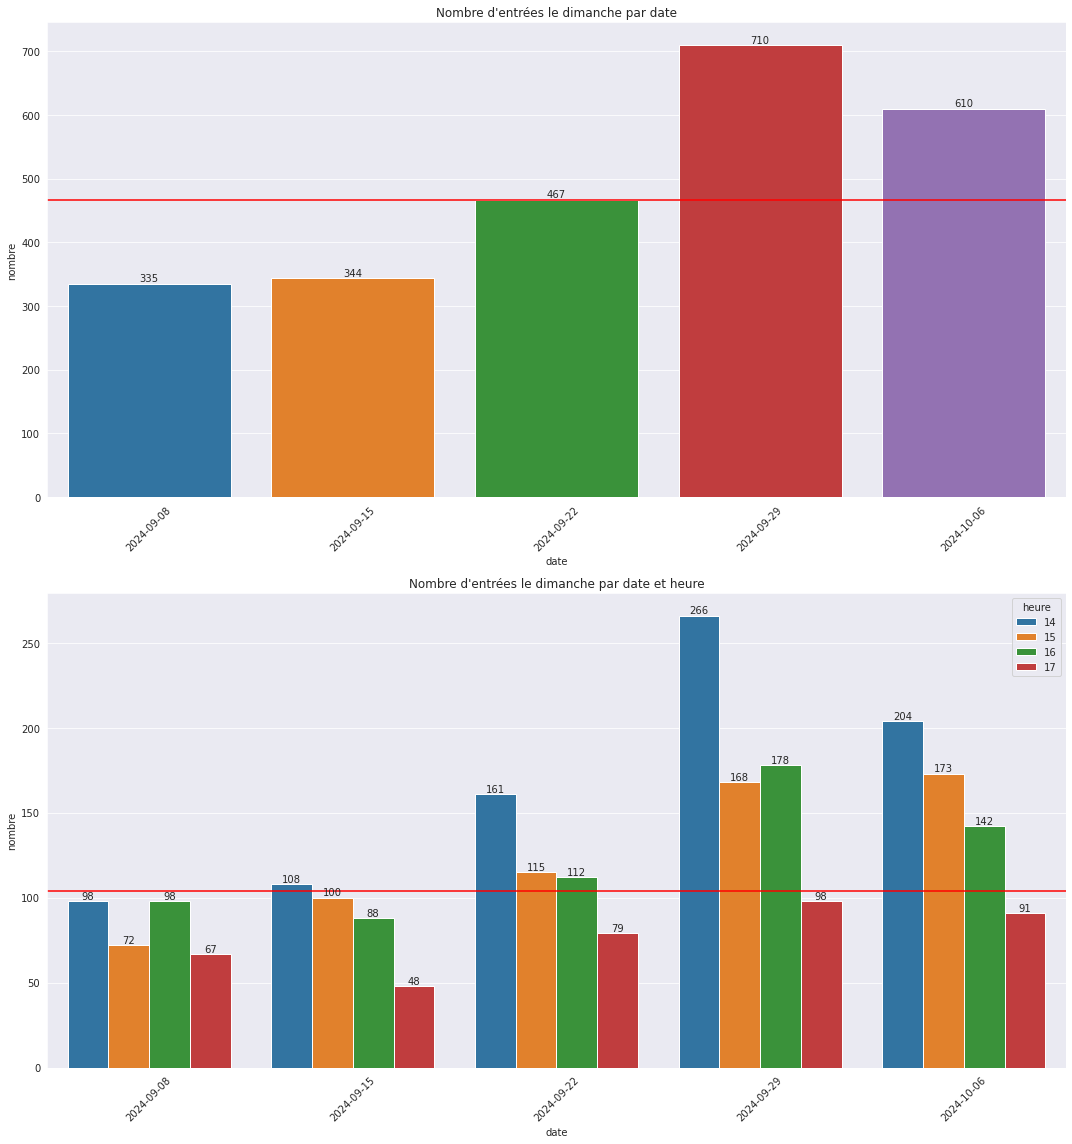

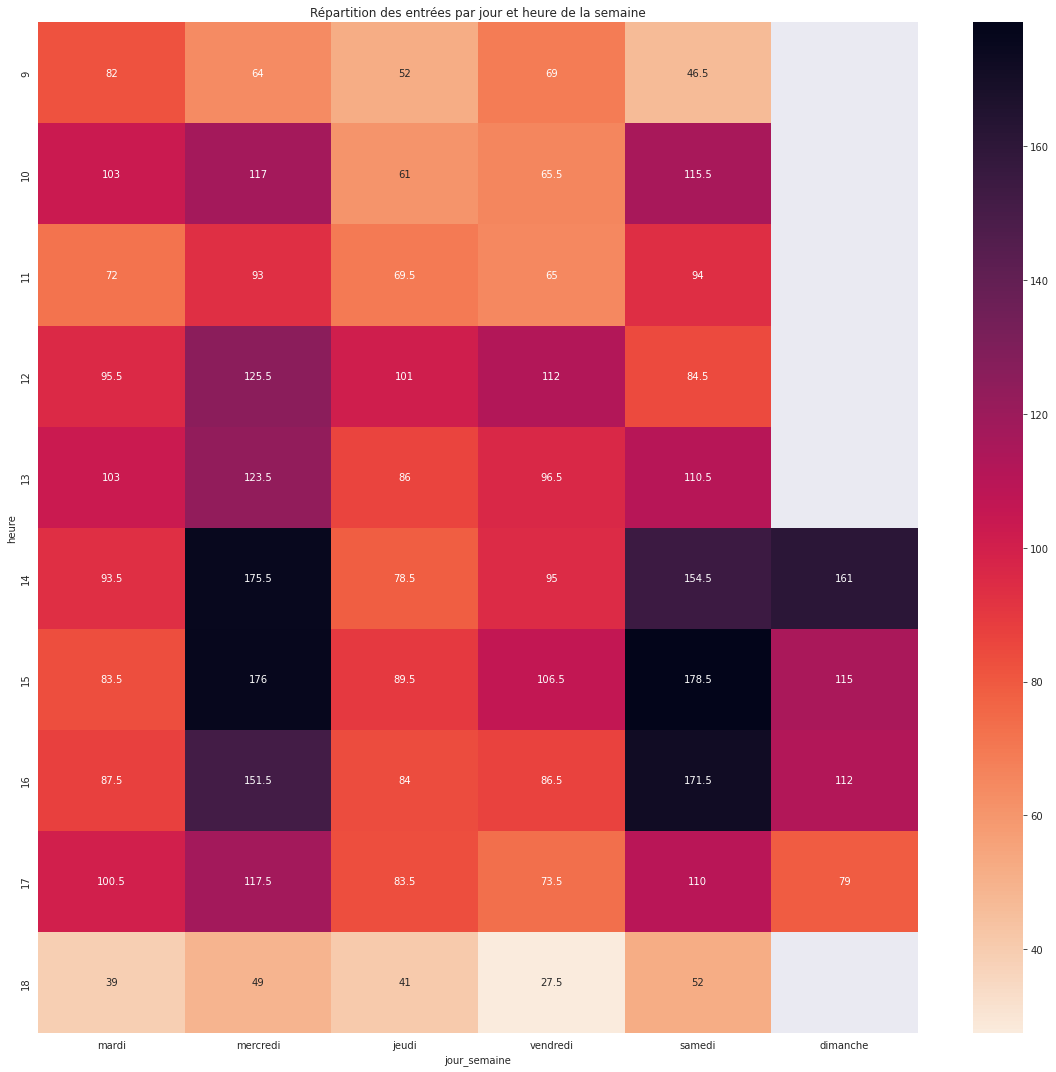

In [7]:
query = f"""SELECT datetime as date_heure, entrees as nombre
FROM stat_entrees
WHERE DATE(datetime) BETWEEN '{date_debut}' AND '{date_fin}'
"""
entrees = StatActivite(db_conn=db_conn, query=query)
entrees.get_df_activite(jourSemaine=6)

n = 2
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

ax[0].axhline(y = entrees.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')
sns.barplot(data=entrees.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title("Nombre d'entrées le dimanche par date")
for i in ax[0].containers:
    ax[0].bar_label(i,)

ax[1].axhline(y = entrees.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
sns.barplot(data=entrees.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title("Nombre d'entrées le dimanche par date et heure")
for i in ax[1].containers:
    ax[1].bar_label(i,)
f.tight_layout()

f, ax = plt.subplots(figsize=(16, 15))
sns.heatmap(entrees.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des entrées par jour et heure de la semaine")
f.tight_layout()

## Prêts

### Ensemble de la Médiathèque

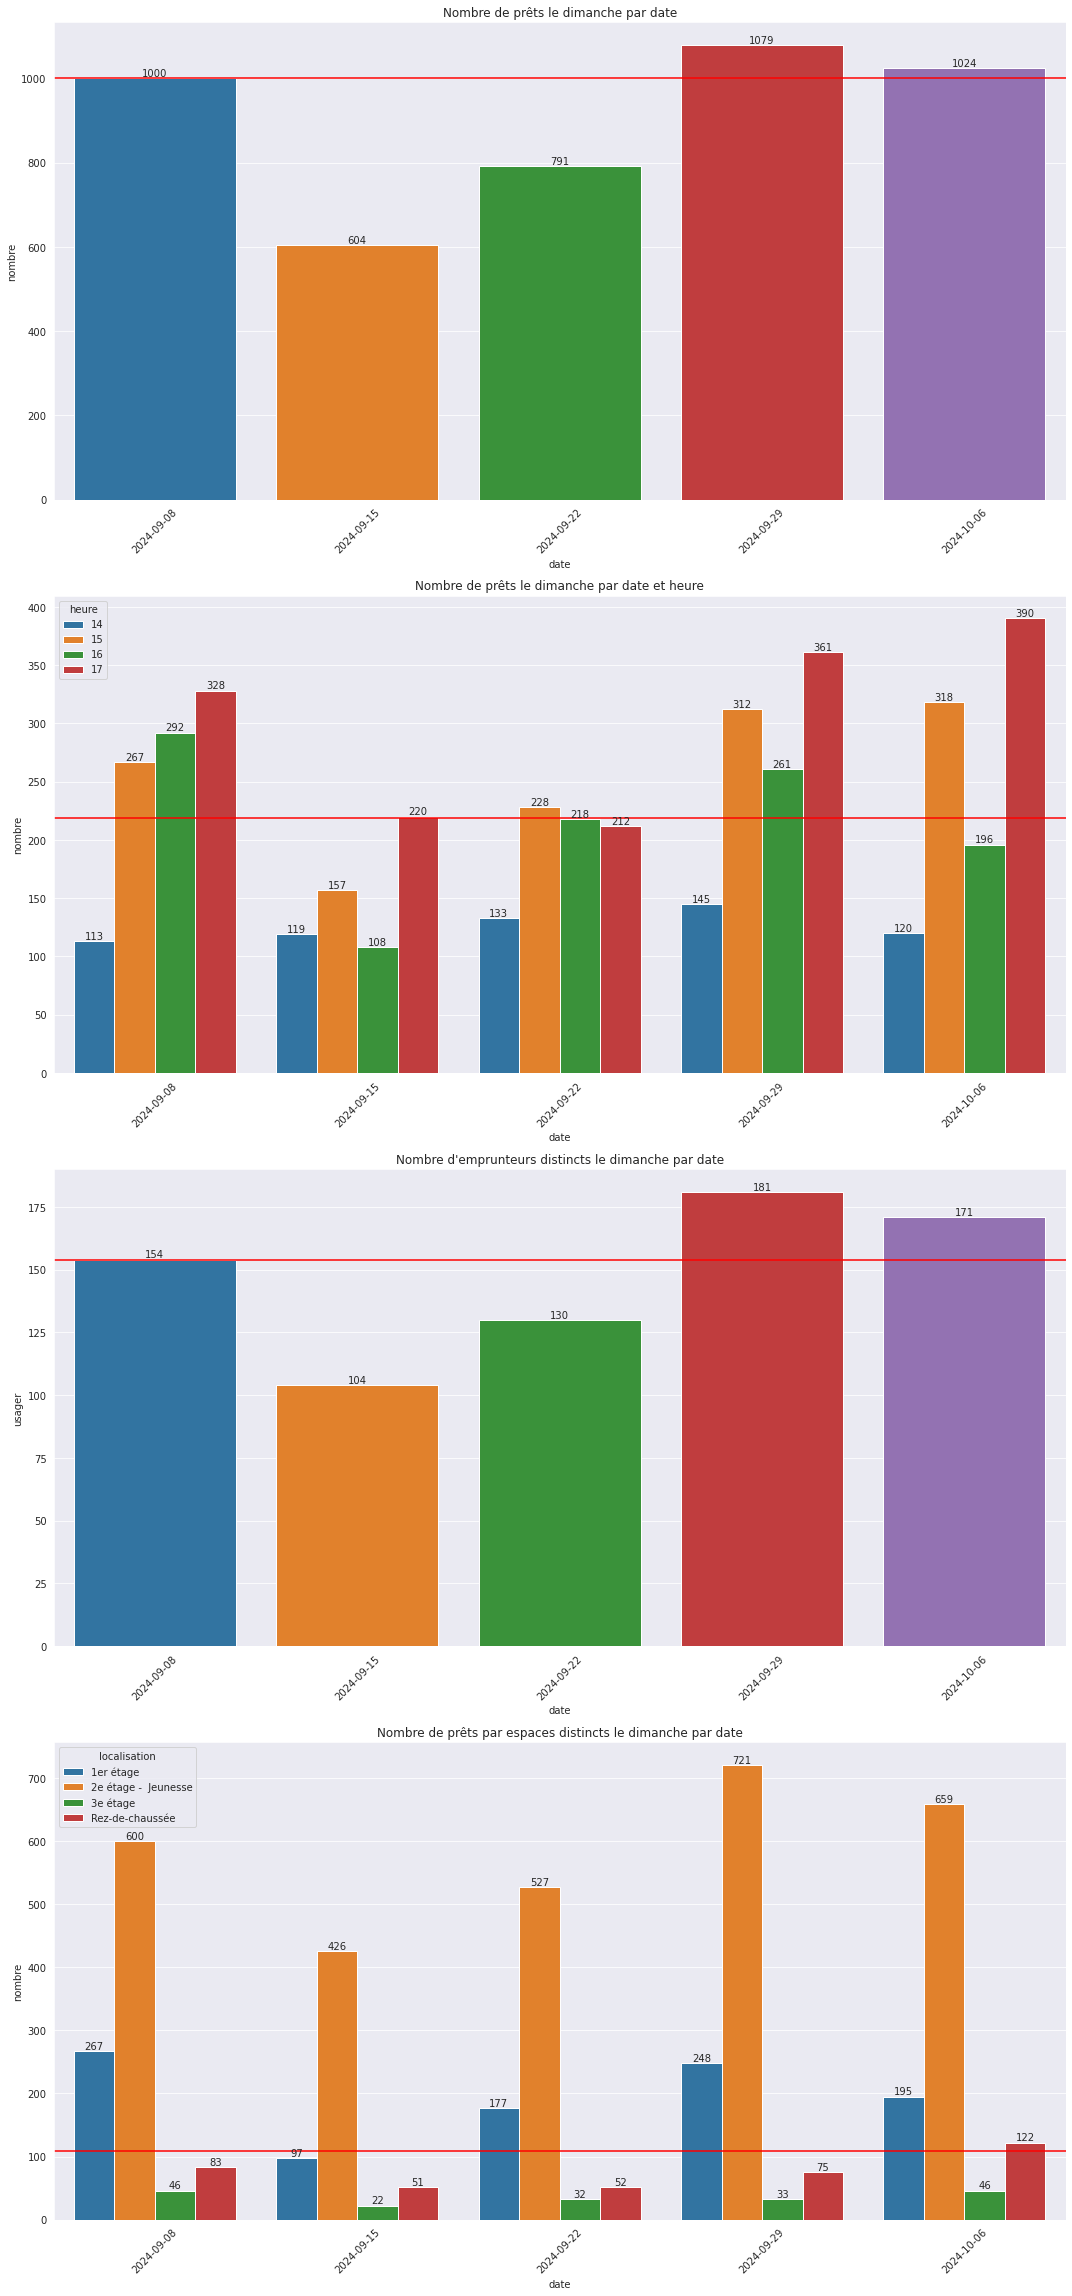

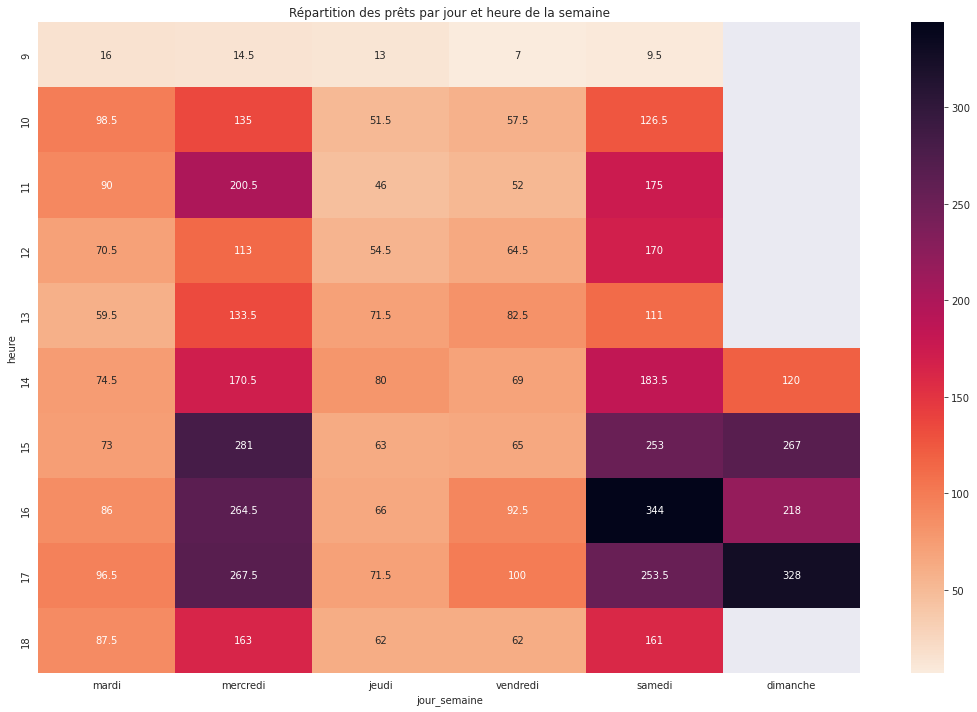

In [8]:
query = f"""SELECT issuedate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(issuedate) BETWEEN '{date_debut}' AND '{date_fin}'
AND location NOT IN ('MED0A', 'BUS1A')
"""
prets = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
prets.get_df_activite(jourSemaine=6)


n = 4
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=prets.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = prets.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=prets.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = prets.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=prets.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = prets.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
    
sns.barplot(data=prets.df_activiteHebdomadaire_parJourLocalisation, x= 'date', y='nombre', hue='localisation', ax=ax[3])
ax[3].axhline(y = prets.df_activiteHebdomadaire_parJourLocalisation['nombre'].median(), color = 'r')    
ax[3].tick_params(axis='x', labelrotation = 45)
ax[3].set_title("Nombre de prêts par espaces distincts le dimanche par date")
for i in ax[3].containers:
    ax[3].bar_label(i,)
f.tight_layout()


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()

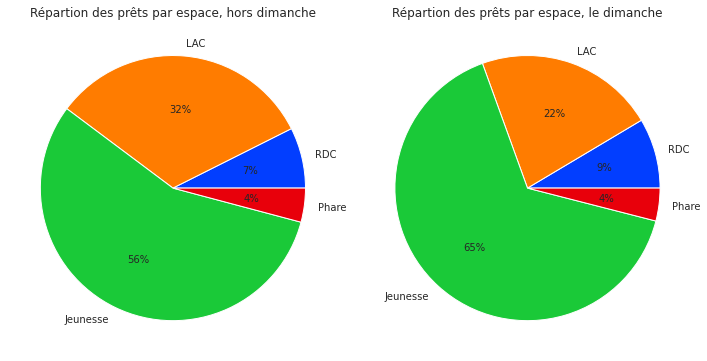

In [9]:
prets.get_df_activiteSemaineVsDimanche()
espaces = {'MED0C':'RDC', 'MED1A':'LAC', 'MED2A':'Jeunesse', 'MED3A':'Phare'}
data_s = prets.df_semaine_parLocalisation['nombre']
keys_s_ = prets.df_semaine_parLocalisation['location']
keys_s = [espaces[k] for k in keys_s_]
data_d = prets.df_dimanche_parLocalisation['nombre']
keys_d_ = prets.df_dimanche_parLocalisation['location']
keys_d = [espaces[k] for k in keys_d_]
   
palette_color = sns.color_palette('bright')
  
f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].pie(data_s, labels=keys_s, colors=palette_color, autopct='%.0f%%')
ax[0].set_title("Répartion des prêts par espace, hors dimanche")
ax[1].pie(data_d, labels=keys_d, colors=palette_color, autopct='%.0f%%')
ax[1].set_title("Répartion des prêts par espace, le dimanche")
f.tight_layout()

## Rez-de-chaussée

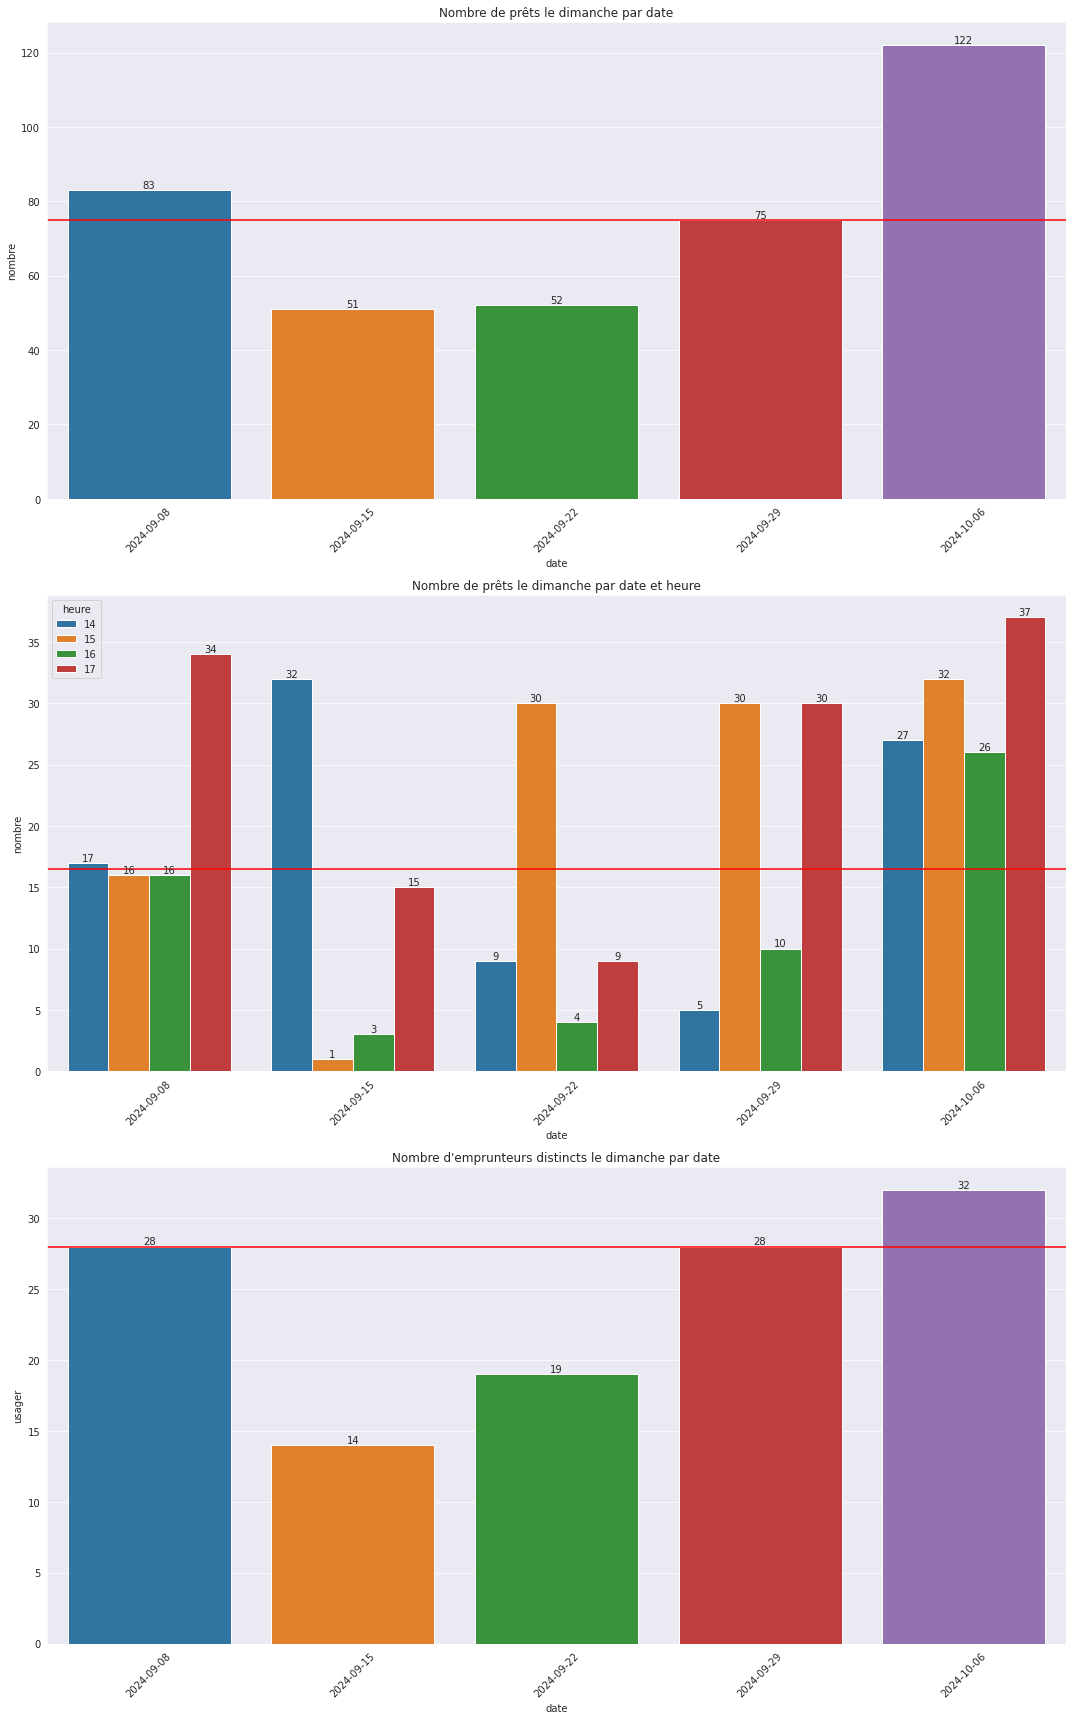

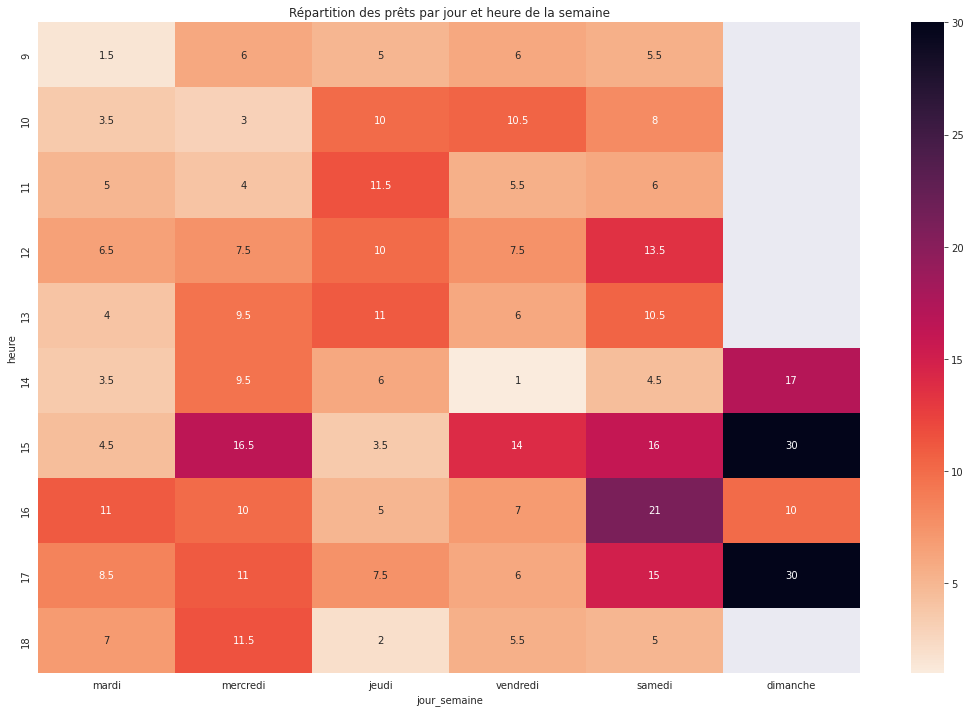

In [10]:
query = f"""SELECT issuedate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(issuedate) BETWEEN '{date_debut}' AND '{date_fin}'
AND location = 'MED0C'
"""

prets = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
prets.get_df_activite(jourSemaine=6)


n = 3
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=prets.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = prets.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=prets.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = prets.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=prets.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = prets.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
    
f.tight_layout()


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()

### LAC

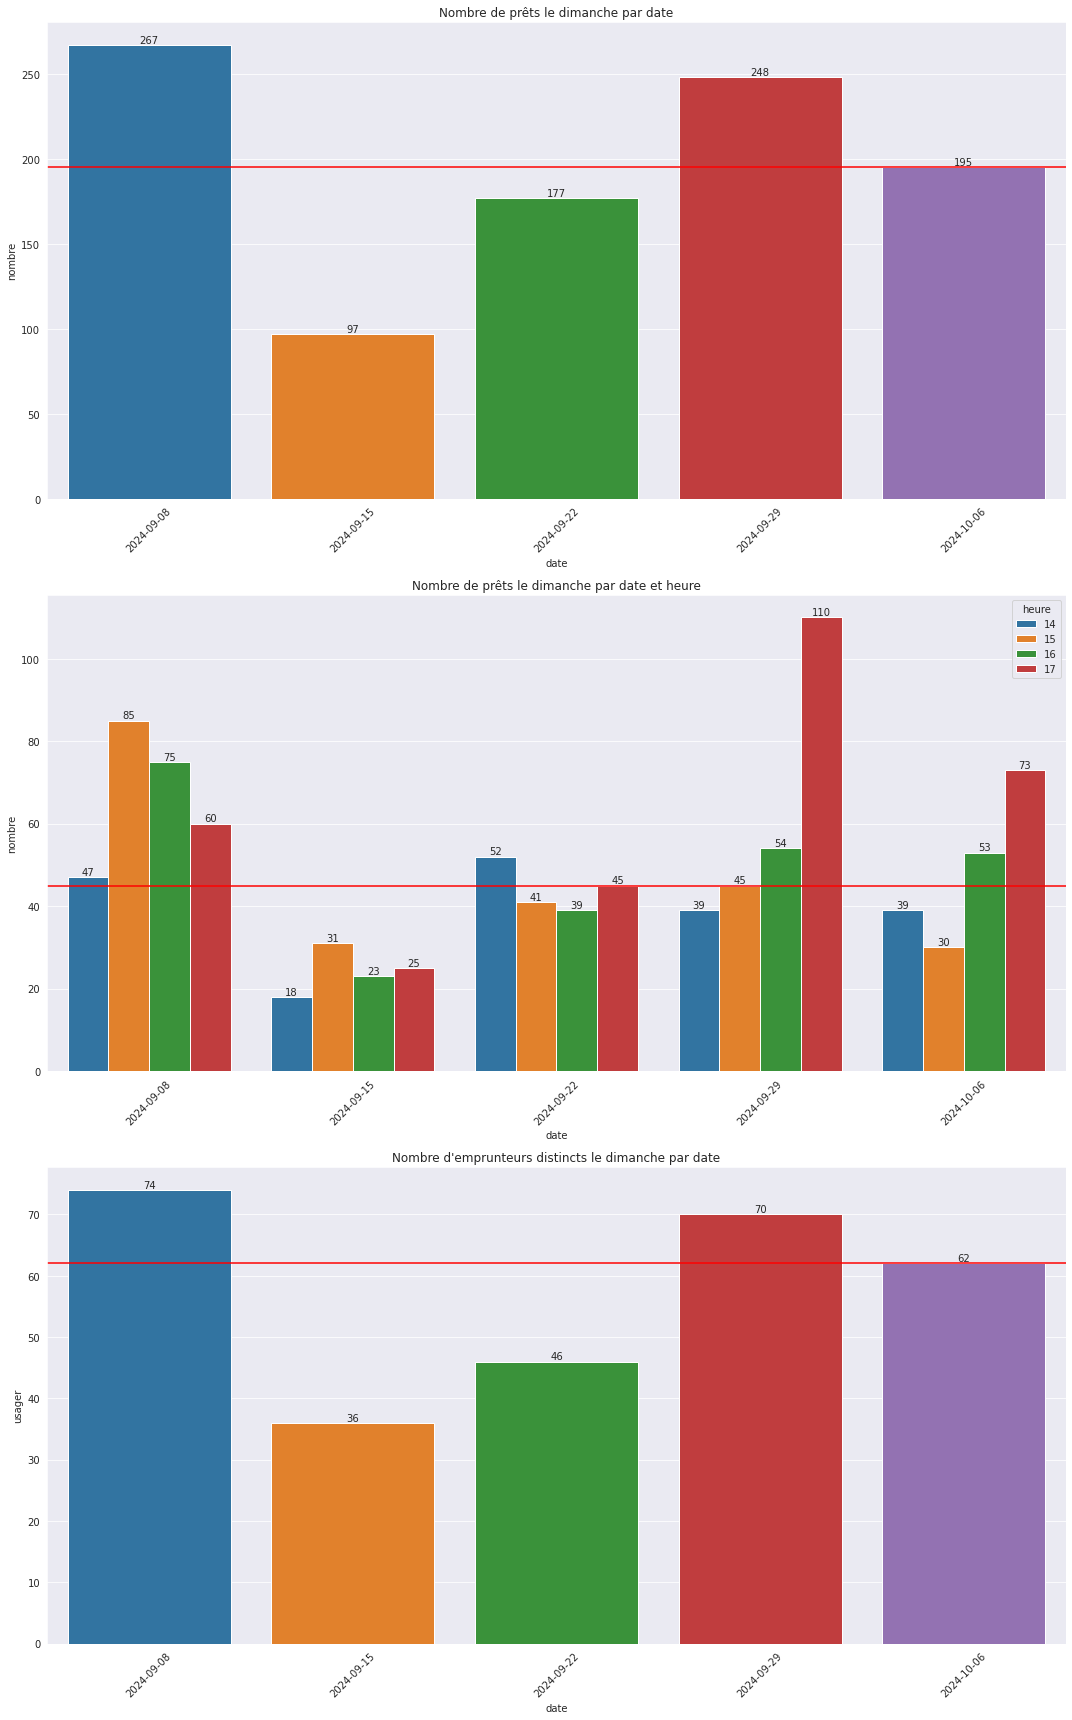

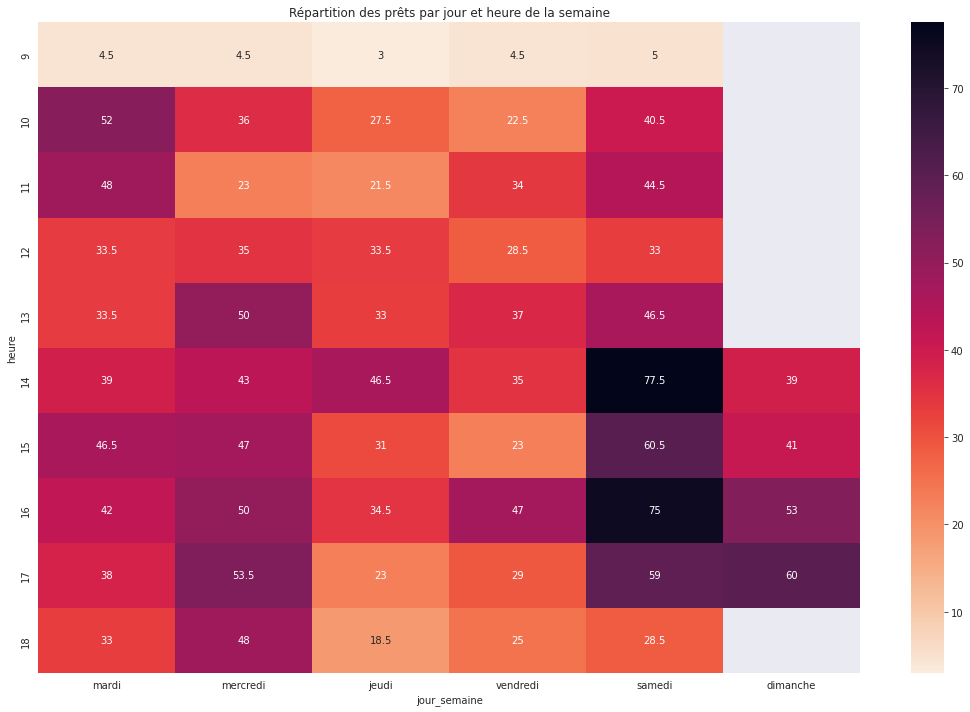

In [11]:
query = f"""SELECT issuedate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(issuedate) BETWEEN '{date_debut}' AND '{date_fin}'
AND location = 'MED1A'
"""

prets = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
prets.get_df_activite(jourSemaine=6)


n = 3
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=prets.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = prets.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=prets.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = prets.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=prets.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = prets.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
    
f.tight_layout()


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()

### Jeunesse

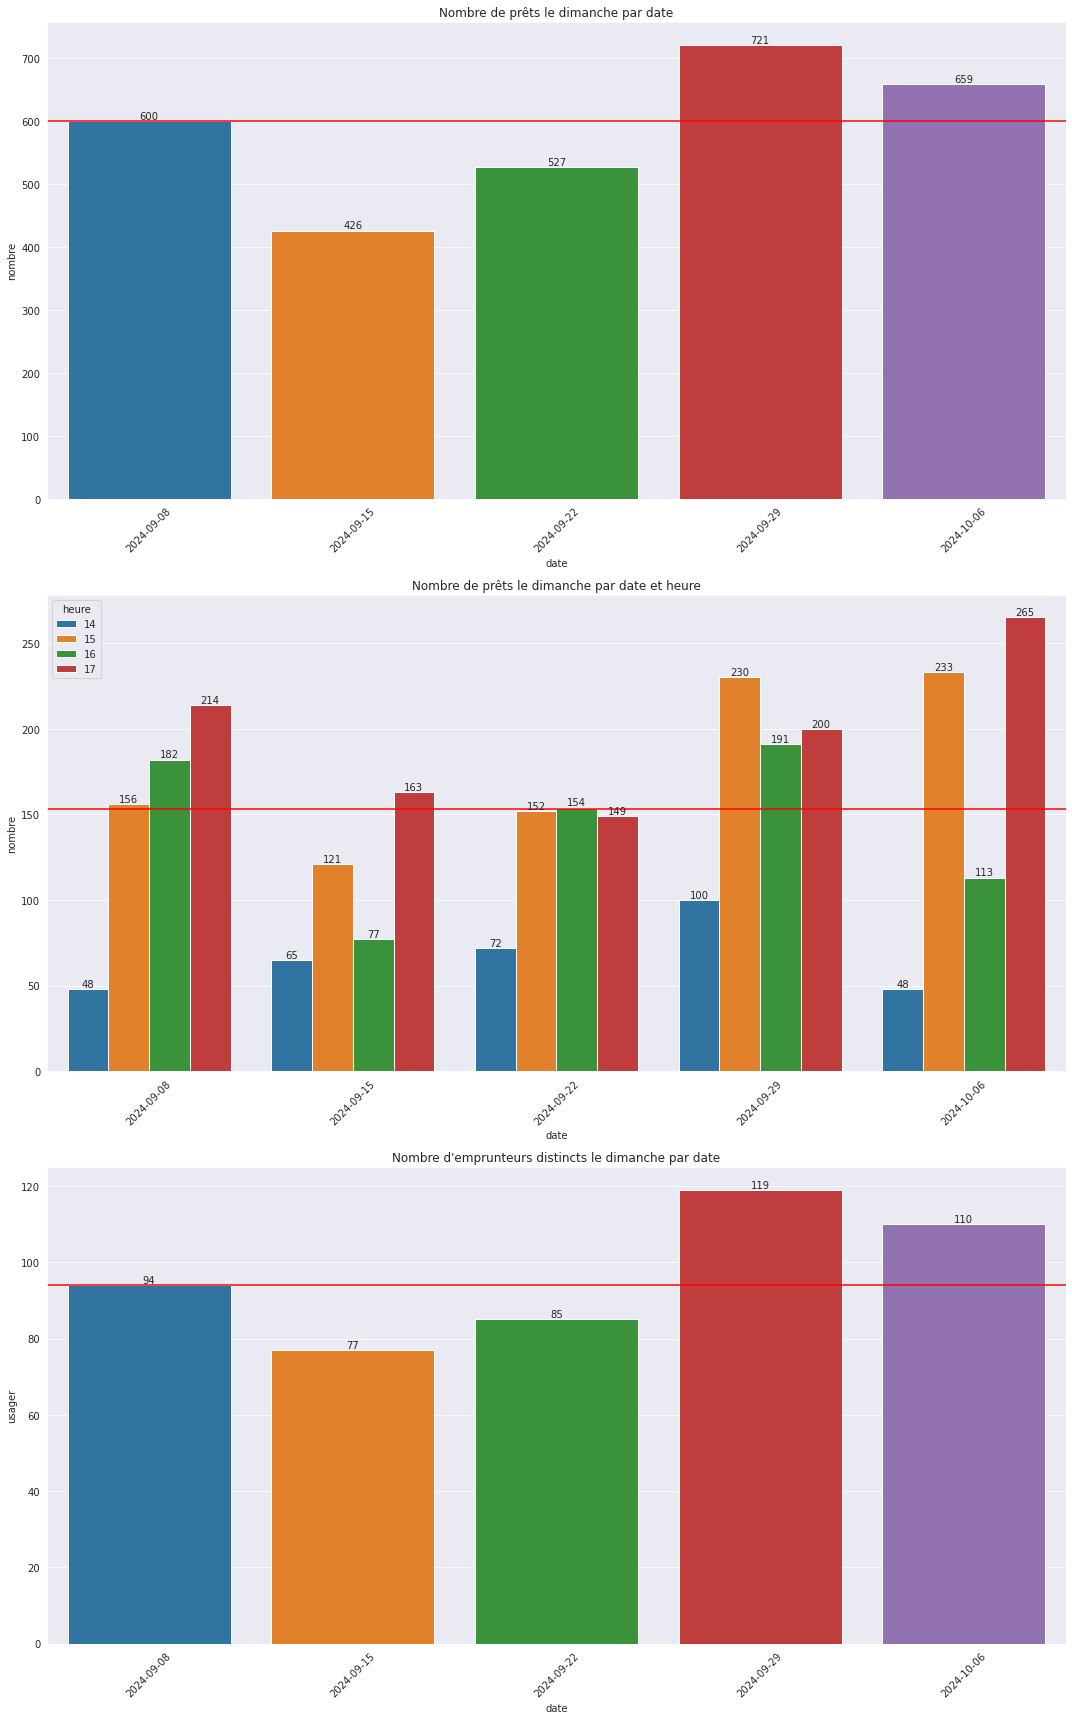

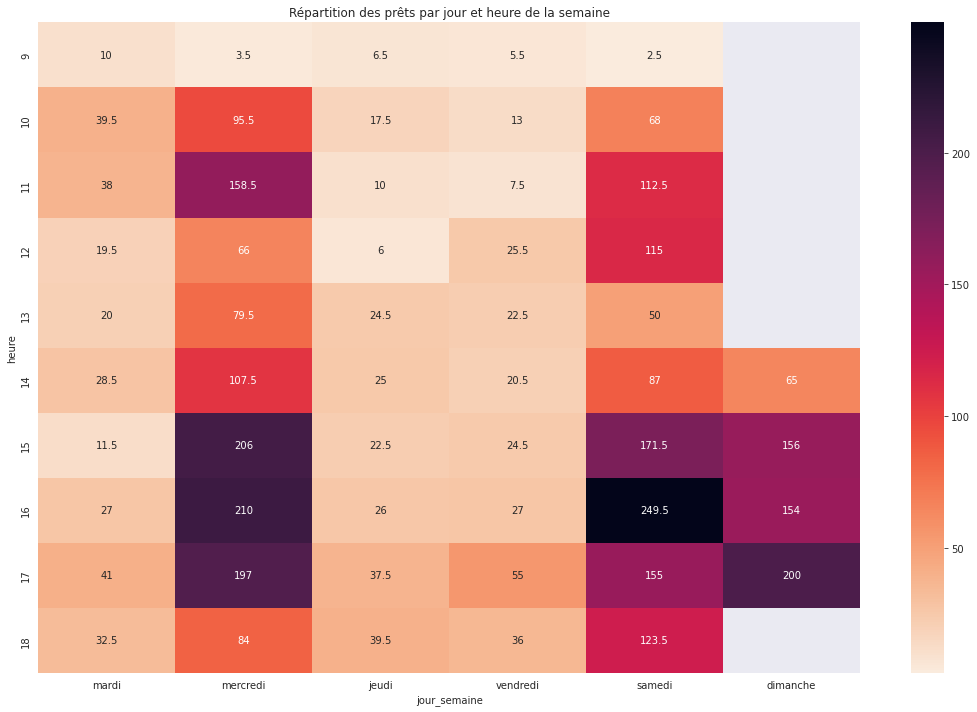

In [12]:
query = f"""SELECT issuedate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(issuedate) BETWEEN '{date_debut}' AND '{date_fin}'
AND location = 'MED2A'
"""

prets = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
prets.get_df_activite(jourSemaine=6)


n = 3
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=prets.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = prets.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=prets.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = prets.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=prets.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = prets.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
    
f.tight_layout()


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()

### Phare

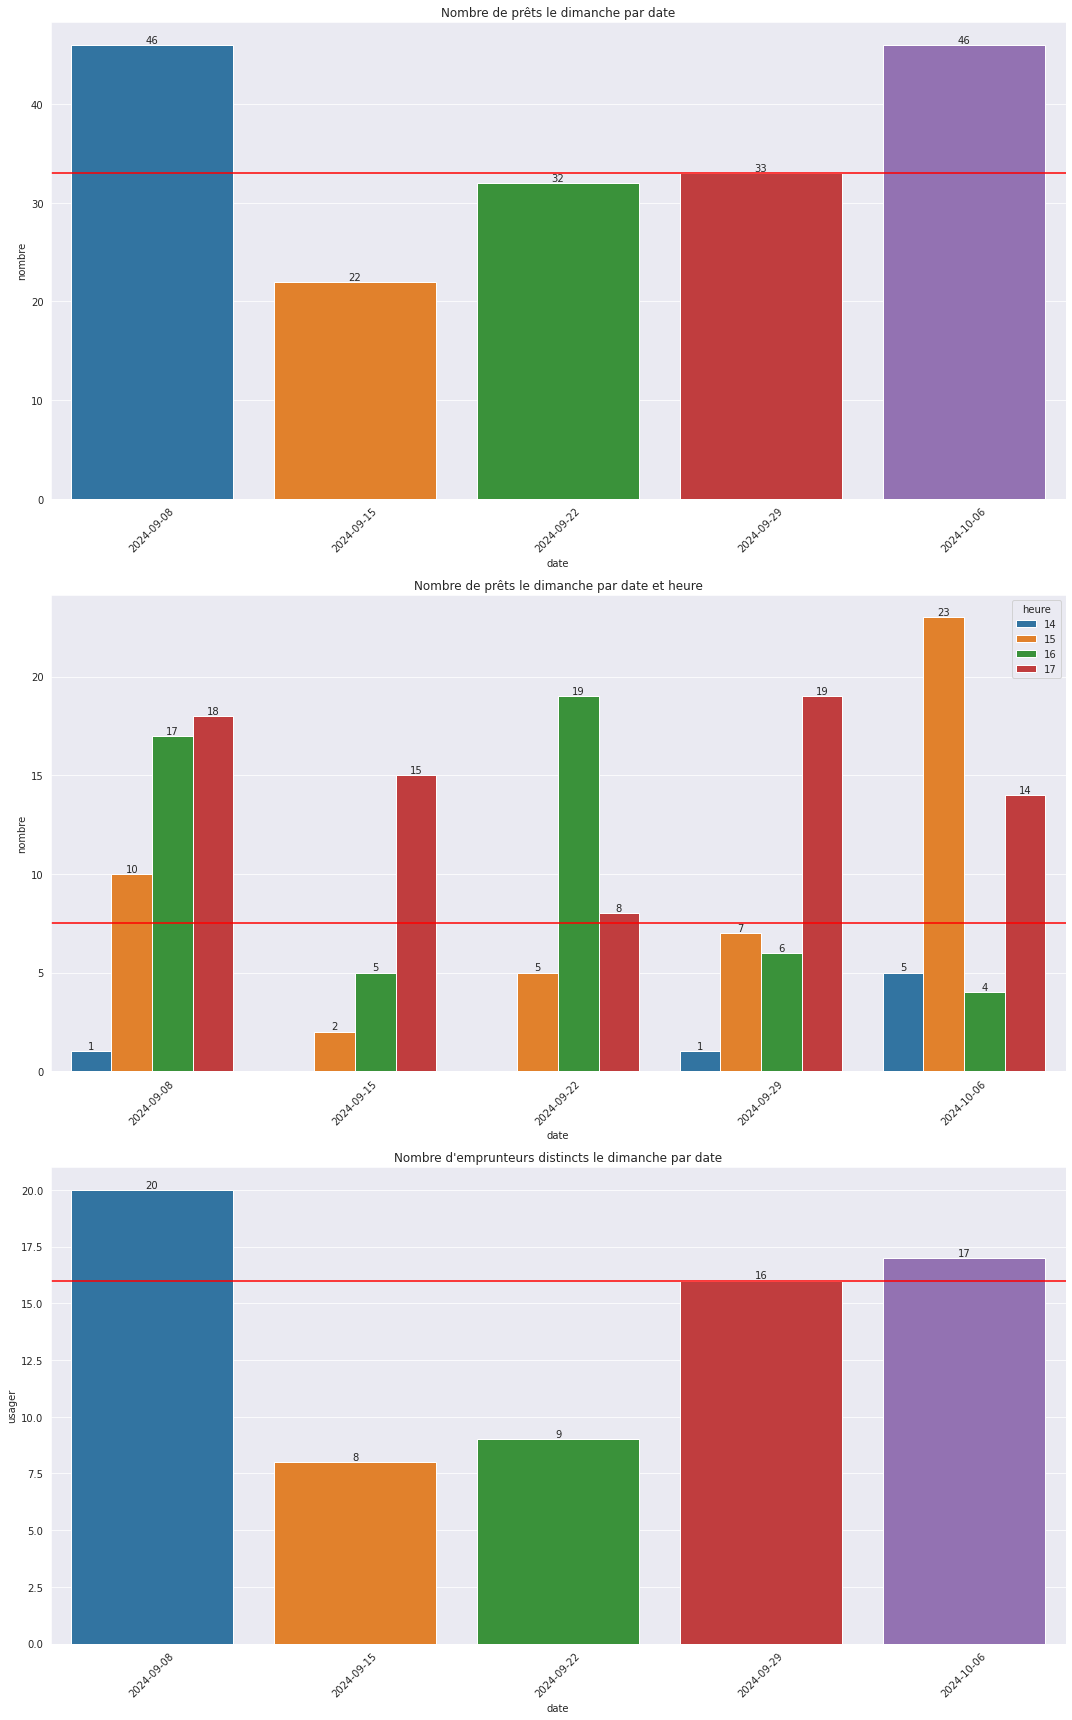

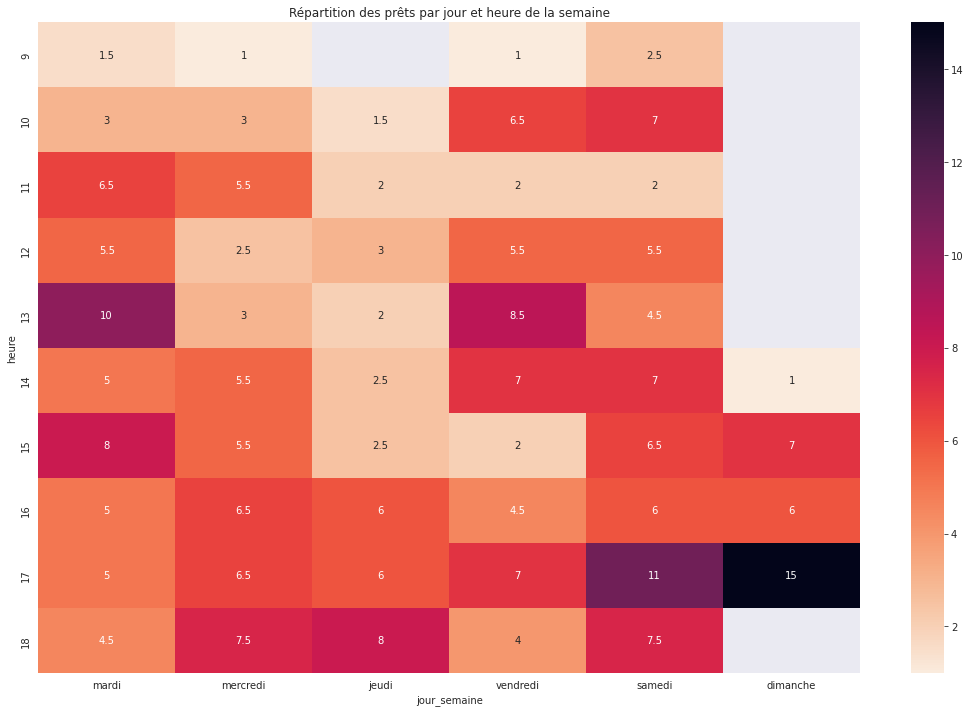

In [13]:
query = f"""SELECT issuedate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(issuedate) BETWEEN '{date_debut}' AND '{date_fin}'
AND location = 'MED3A'
"""

prets = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
prets.get_df_activite(jourSemaine=6)


n = 3
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=prets.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = prets.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de prêts le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=prets.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = prets.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de prêts le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=prets.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = prets.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre d'emprunteurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
    
f.tight_layout()


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(prets.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des prêts par jour et heure de la semaine")
f.tight_layout()

## Retours

### Ensemble de la médiathèque

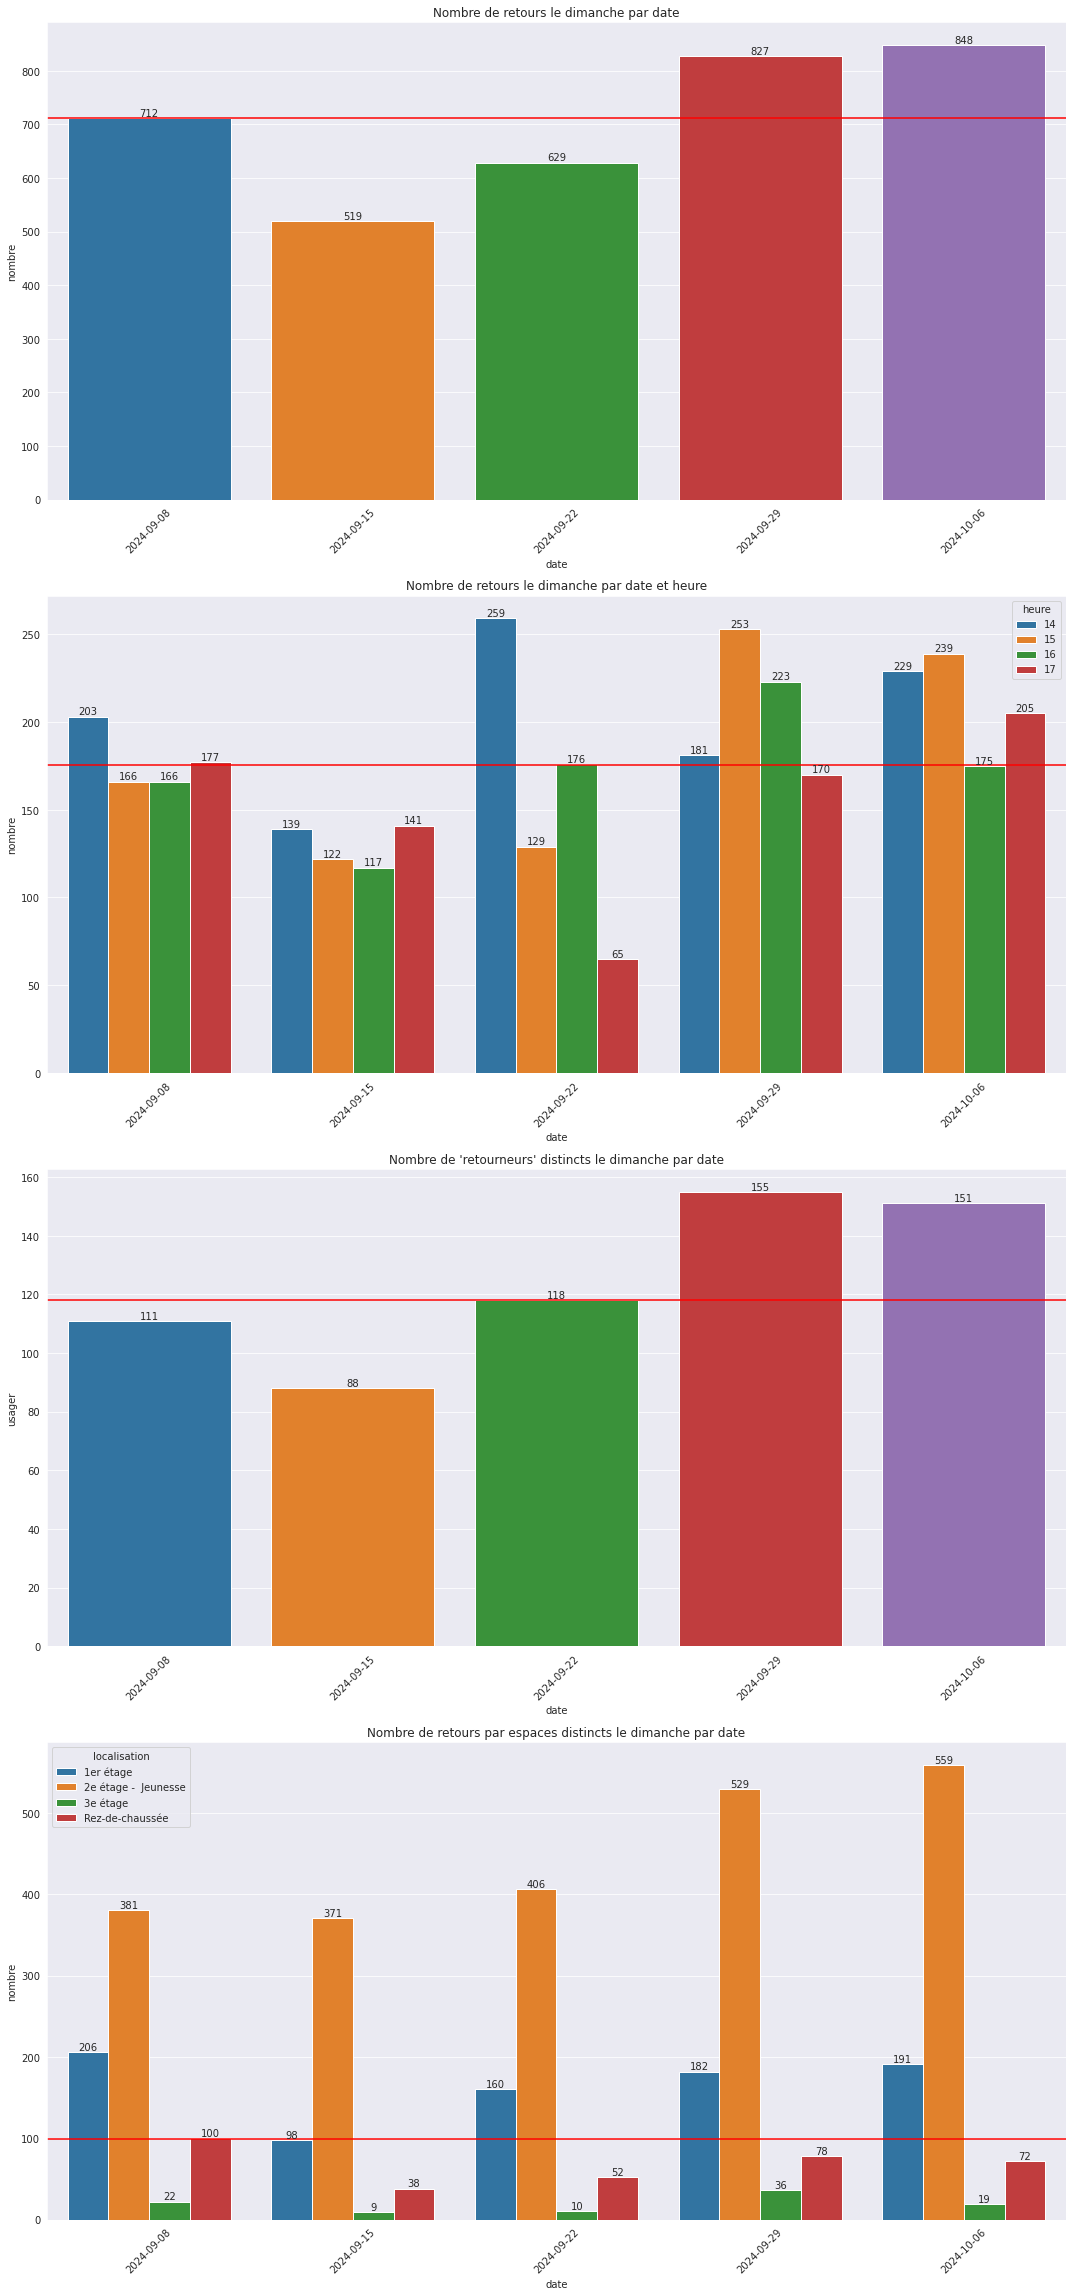

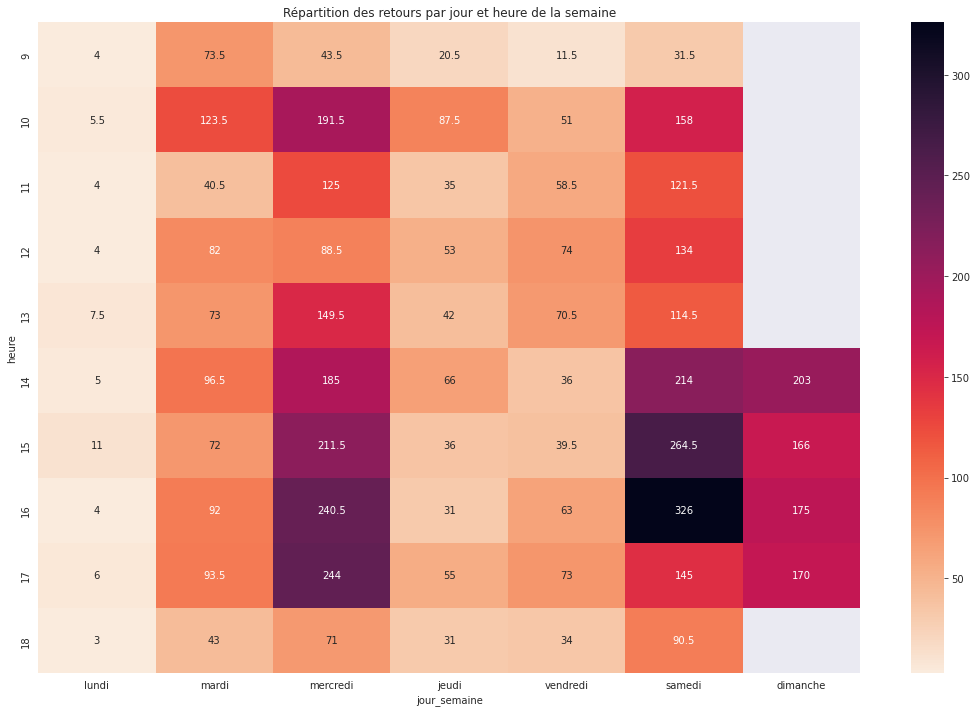

In [14]:
query = f"""SELECT returndate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(returndate) BETWEEN '{date_debut}' AND '{date_fin}'
AND location NOT IN ('MED0A', 'BUS1A')
"""

retours = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
retours.get_df_activite(jourSemaine=6)


n = 4
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=retours.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = retours.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de retours le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=retours.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = retours.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de retours le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=retours.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = retours.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre de 'retourneurs' distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
    
sns.barplot(data=retours.df_activiteHebdomadaire_parJourLocalisation, x= 'date', y='nombre', hue='localisation', ax=ax[3])
ax[3].axhline(y = retours.df_activiteHebdomadaire_parJourLocalisation['nombre'].median(), color = 'r')    
ax[3].tick_params(axis='x', labelrotation = 45)
ax[3].set_title("Nombre de retours par espaces distincts le dimanche par date")
for i in ax[3].containers:
    ax[3].bar_label(i,)
f.tight_layout()


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(retours.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des retours par jour et heure de la semaine")
f.tight_layout()

### Rez-de-chaussée

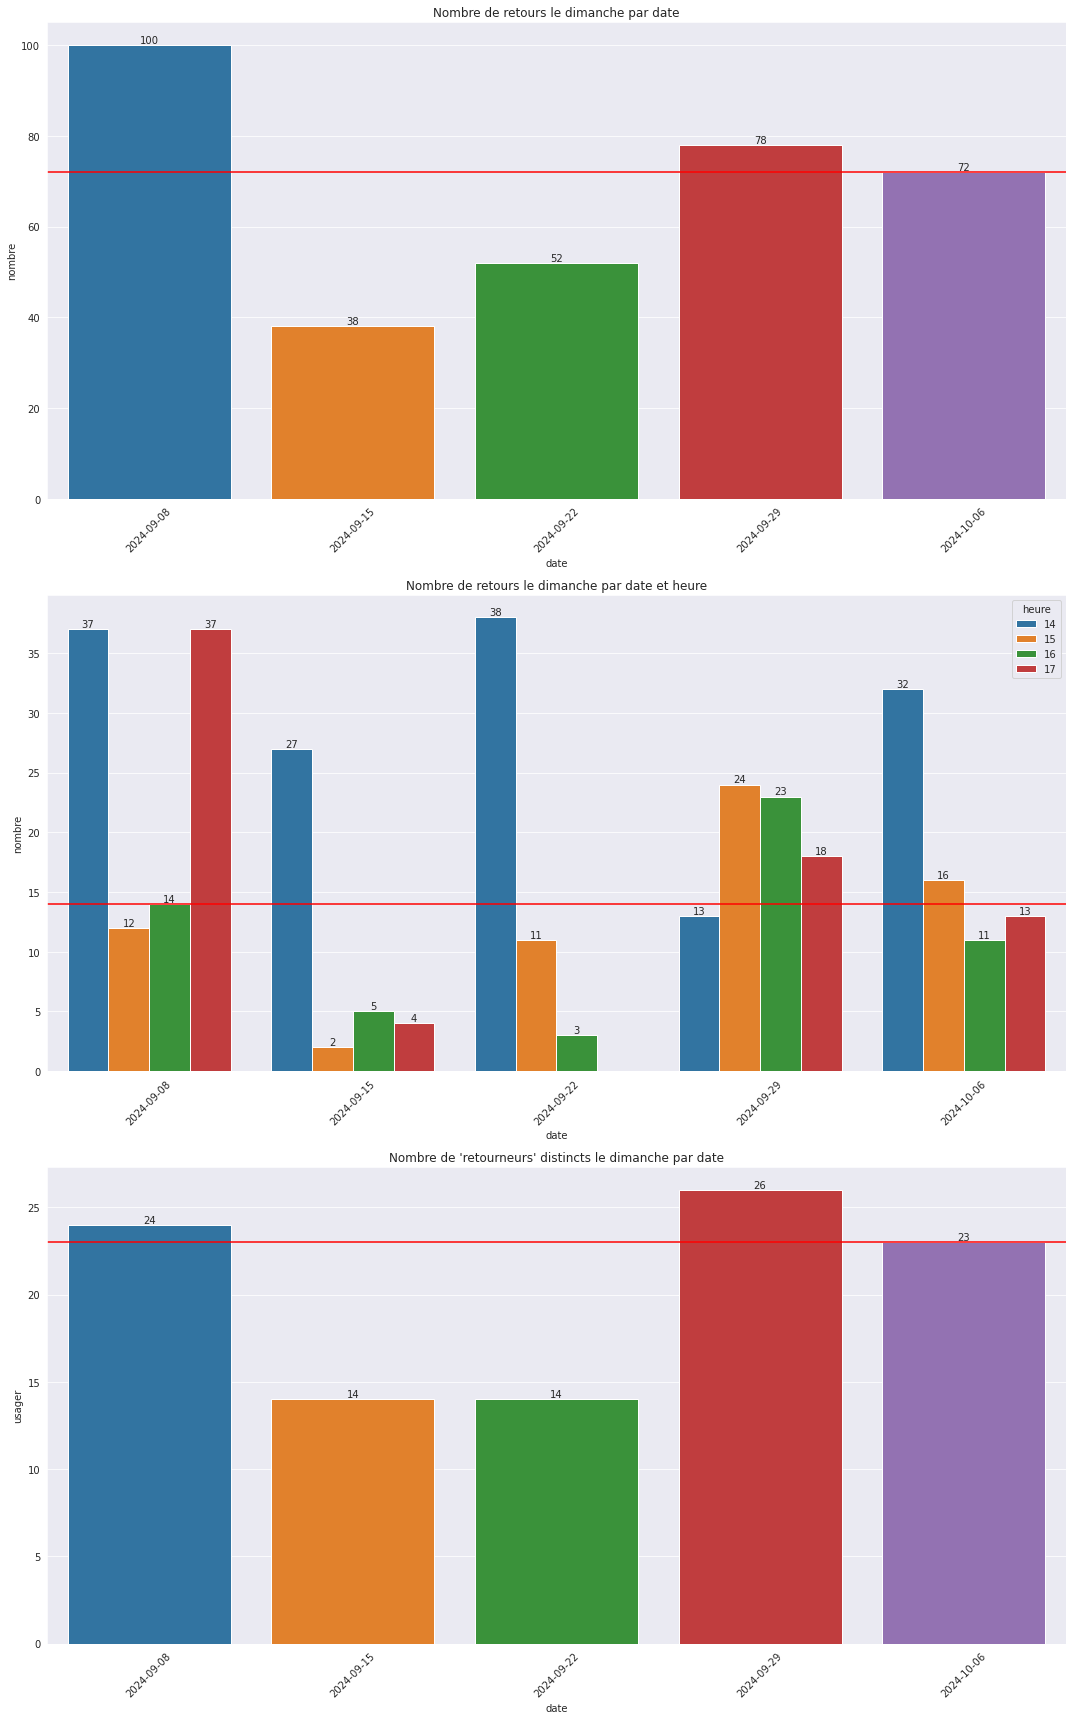

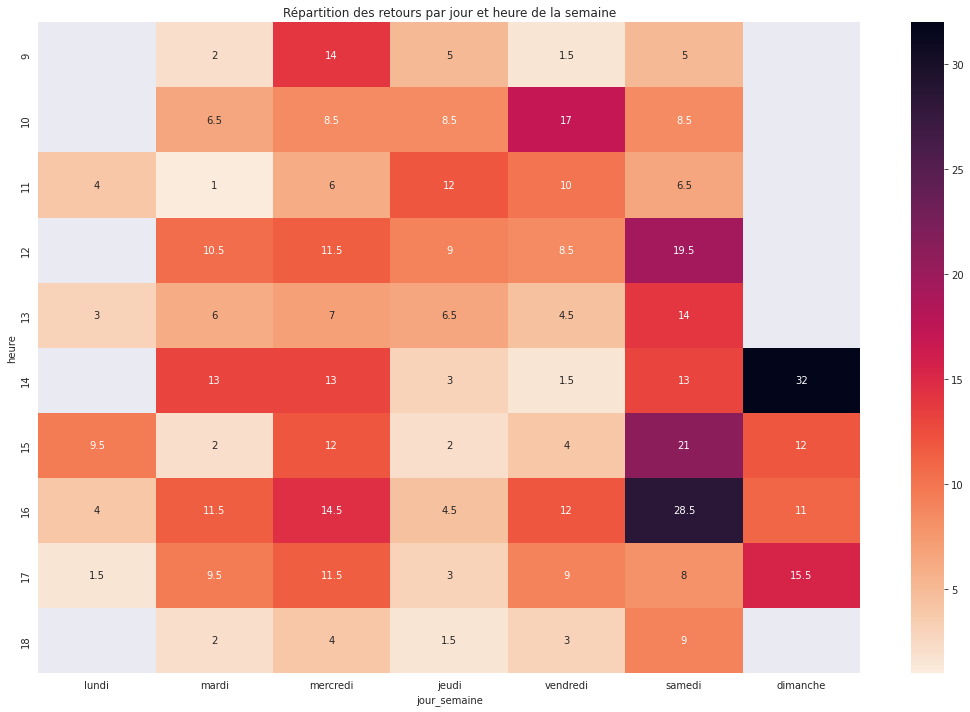

In [15]:
query = f"""SELECT returndate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(returndate) BETWEEN '{date_debut}' AND '{date_fin}'
AND location = 'MED0C'
"""

retours = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
retours.get_df_activite(jourSemaine=6)


n = 3
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=retours.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = retours.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de retours le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=retours.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = retours.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de retours le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=retours.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = retours.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre de 'retourneurs' distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
f.tight_layout()


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(retours.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des retours par jour et heure de la semaine")
f.tight_layout()

### LAC

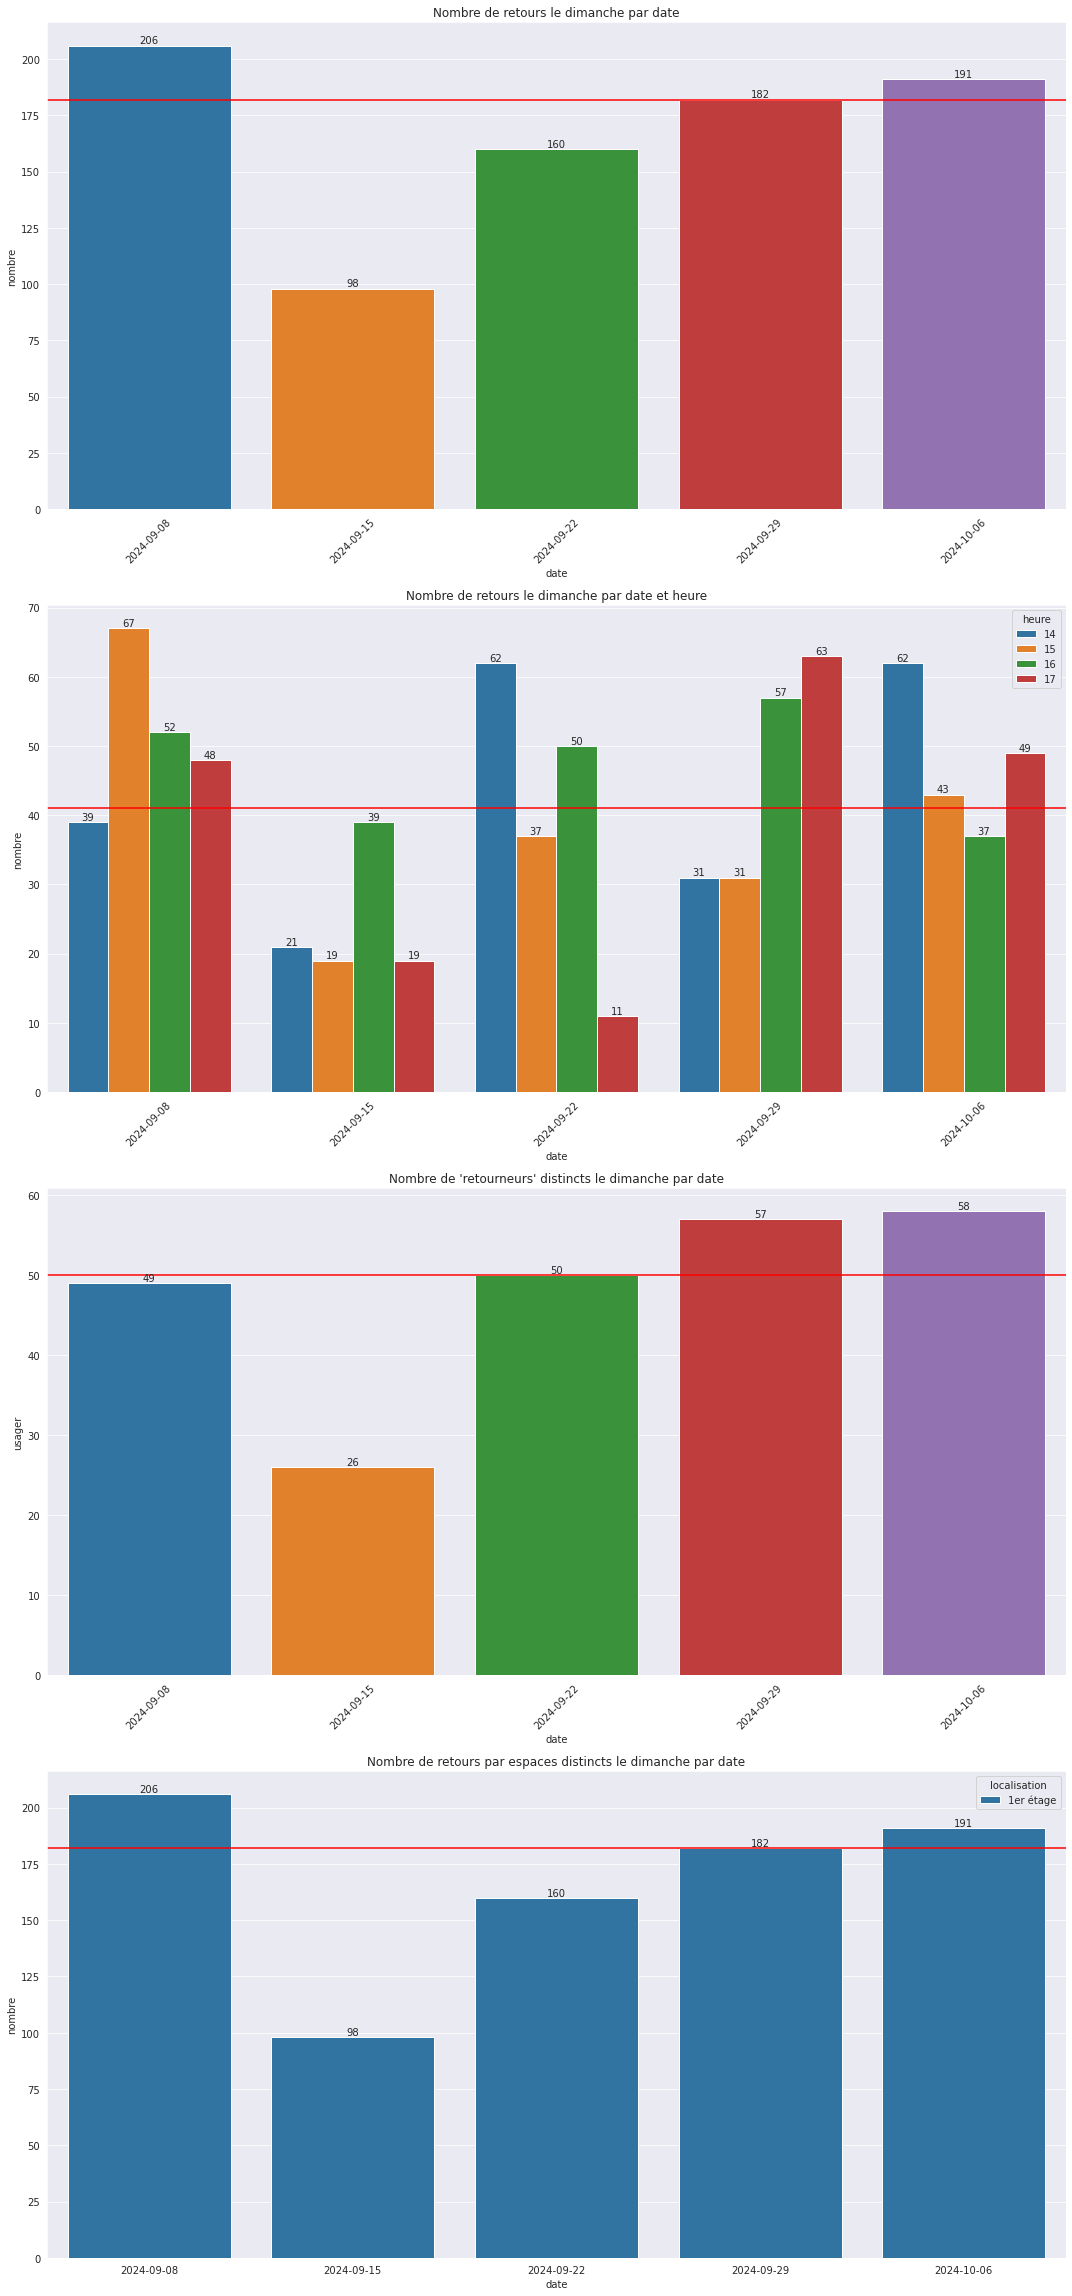

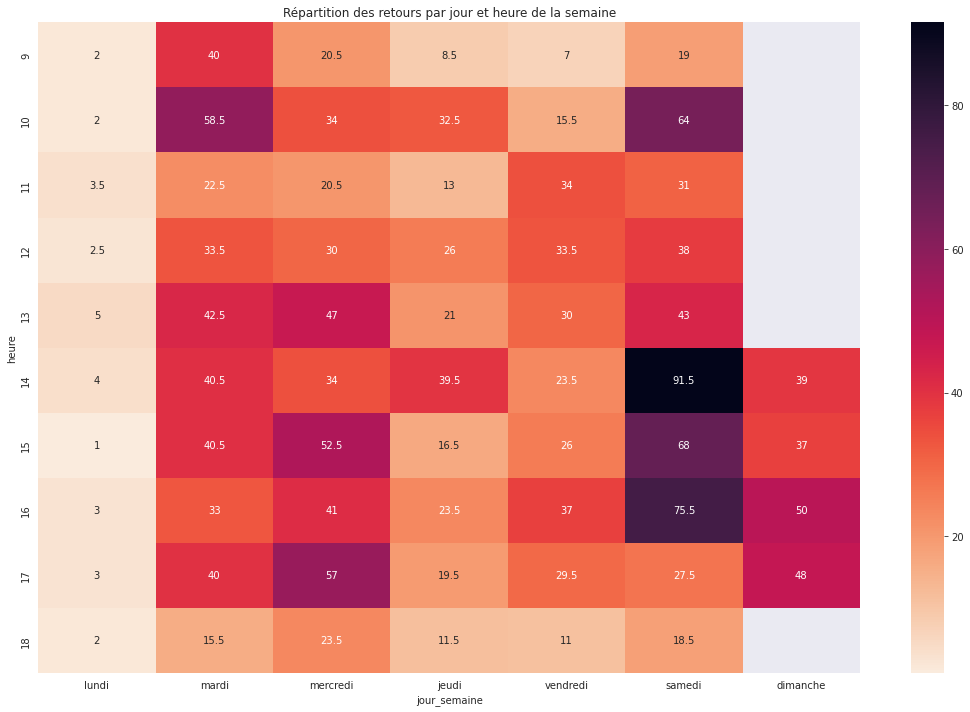

In [16]:
query = f"""SELECT returndate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(returndate) BETWEEN '{date_debut}' AND '{date_fin}'
AND location = 'MED1A'
"""

retours = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
retours.get_df_activite(jourSemaine=6)


n = 4
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=retours.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = retours.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de retours le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=retours.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = retours.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de retours le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=retours.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = retours.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre de 'retourneurs' distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
    
sns.barplot(data=retours.df_activiteHebdomadaire_parJourLocalisation, x= 'date', y='nombre', hue='localisation', ax=ax[3])
ax[3].axhline(y = retours.df_activiteHebdomadaire_parJourLocalisation['nombre'].median(), color = 'r')    
ax[3].set_title("Nombre de retours par espaces distincts le dimanche par date")
for i in ax[3].containers:
    ax[3].bar_label(i,)
f.tight_layout()


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(retours.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des retours par jour et heure de la semaine")
f.tight_layout()

### Jeunesse

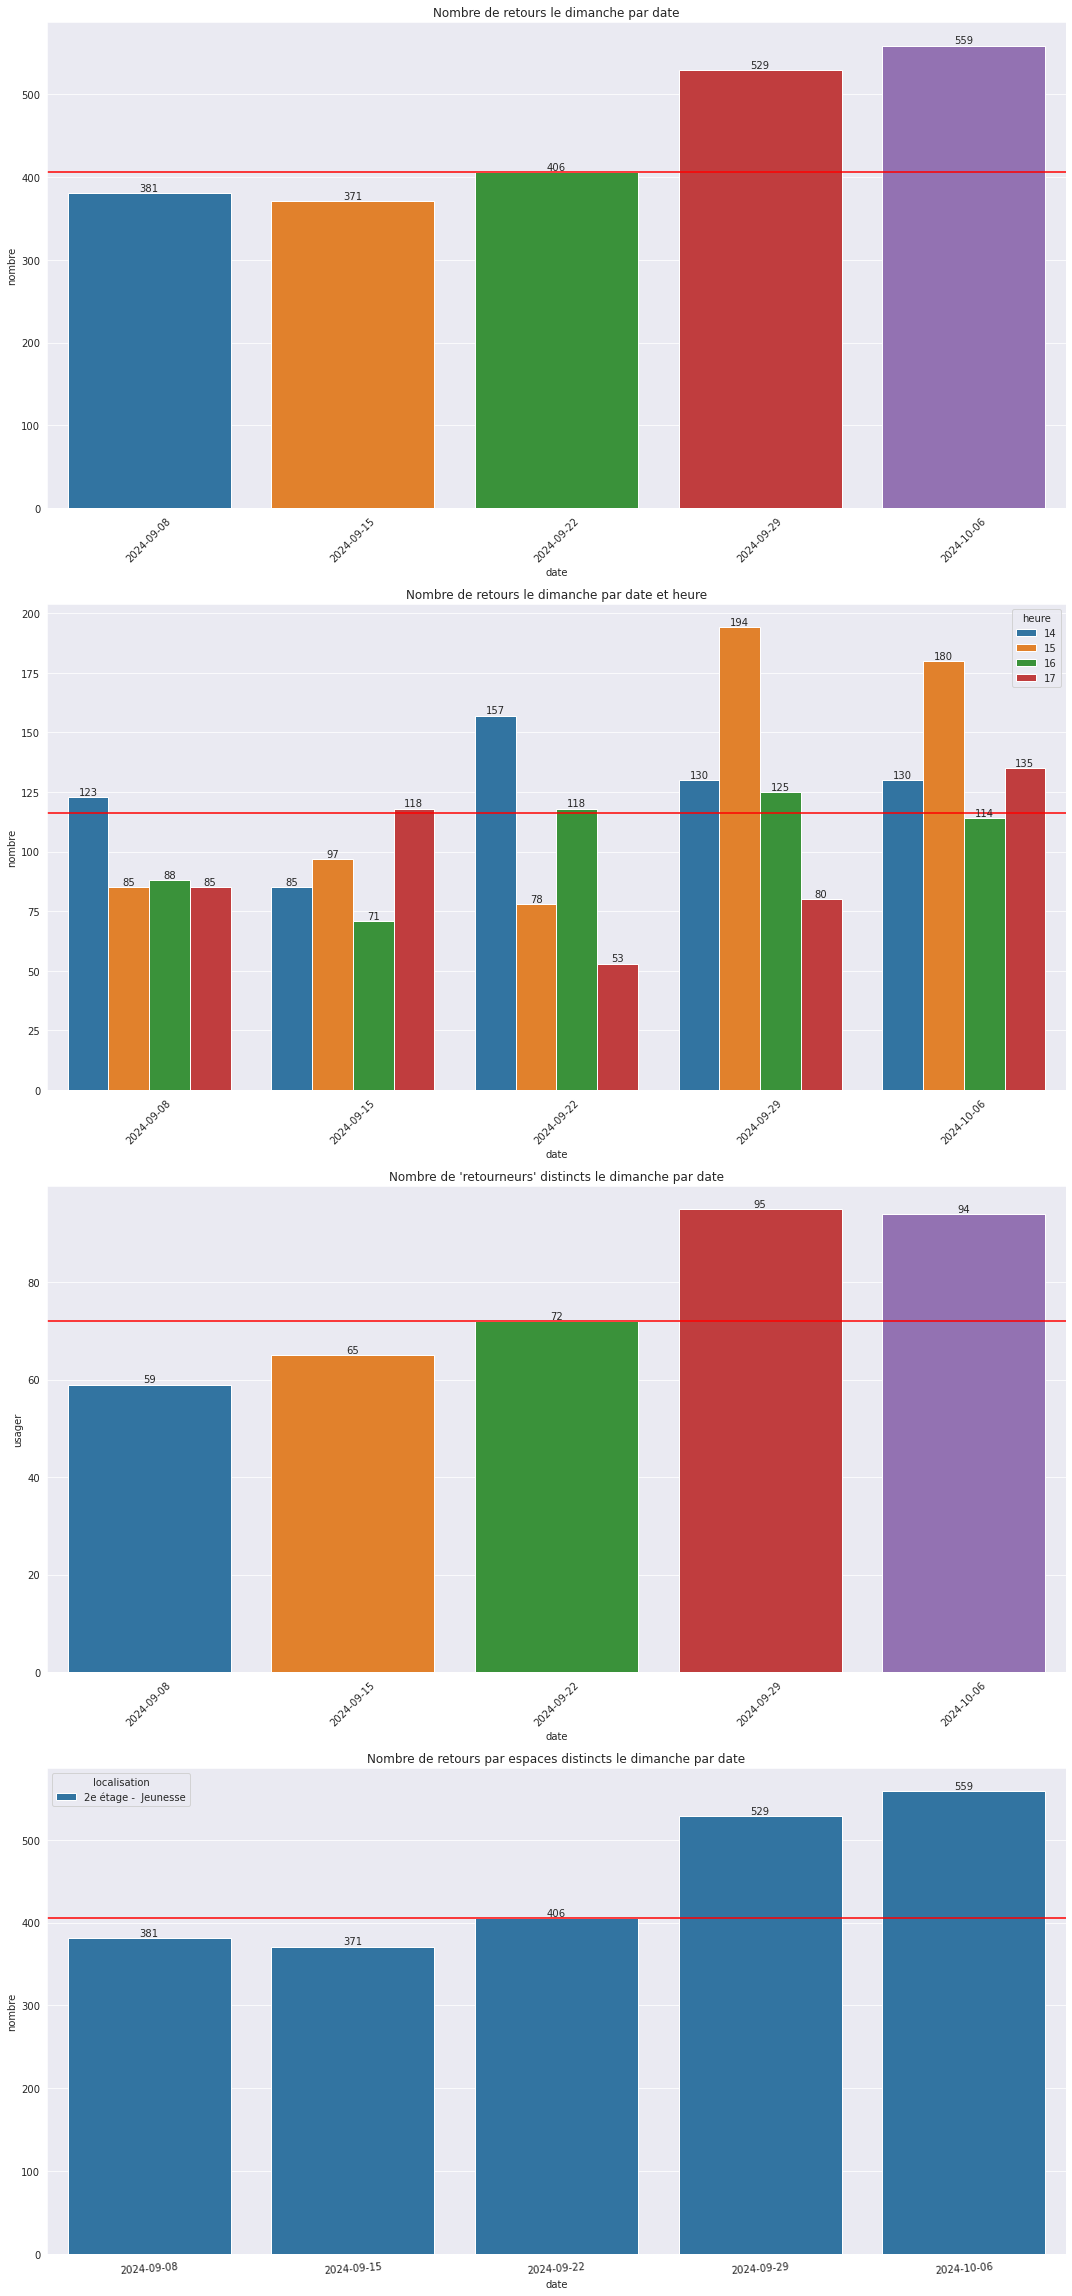

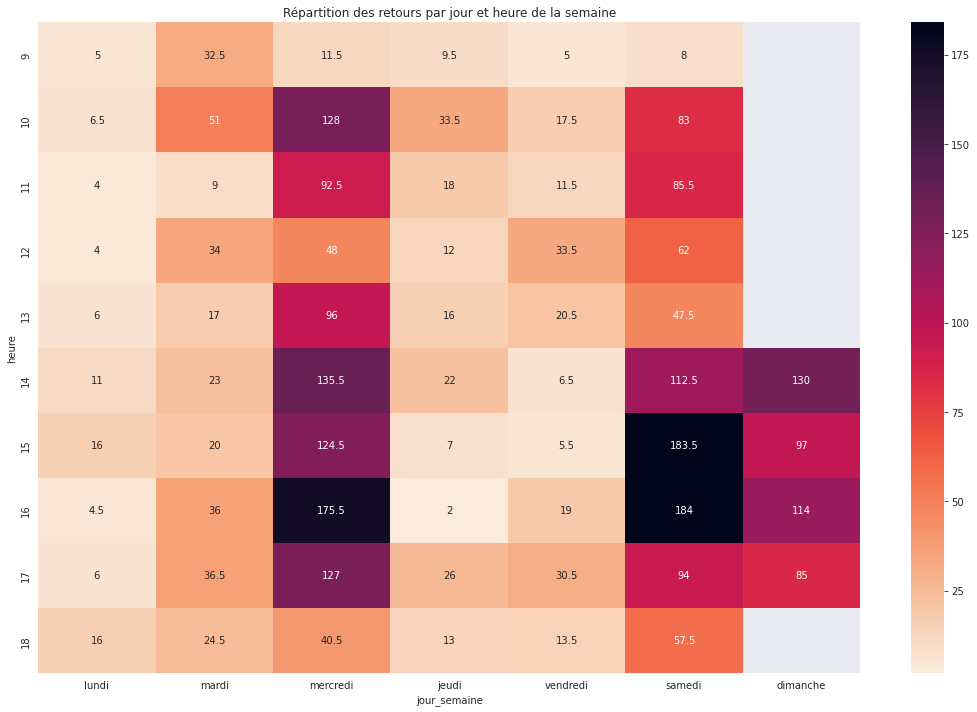

In [17]:
query = f"""SELECT returndate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(returndate) BETWEEN '{date_debut}' AND '{date_fin}'
AND location = 'MED2A'
"""

retours = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
retours.get_df_activite(jourSemaine=6)


n = 4
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=retours.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = retours.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de retours le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=retours.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = retours.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de retours le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=retours.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = retours.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre de 'retourneurs' distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
    
sns.barplot(data=retours.df_activiteHebdomadaire_parJourLocalisation, x= 'date', y='nombre', hue='localisation', ax=ax[3])
ax[3].axhline(y = retours.df_activiteHebdomadaire_parJourLocalisation['nombre'].median(), color = 'r') 
ax[3].tick_params(axis='x', labelrotation = 4)
ax[3].set_title("Nombre de retours par espaces distincts le dimanche par date")
for i in ax[3].containers:
    ax[3].bar_label(i,)
f.tight_layout()


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(retours.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des retours par jour et heure de la semaine")
f.tight_layout()

### Phare

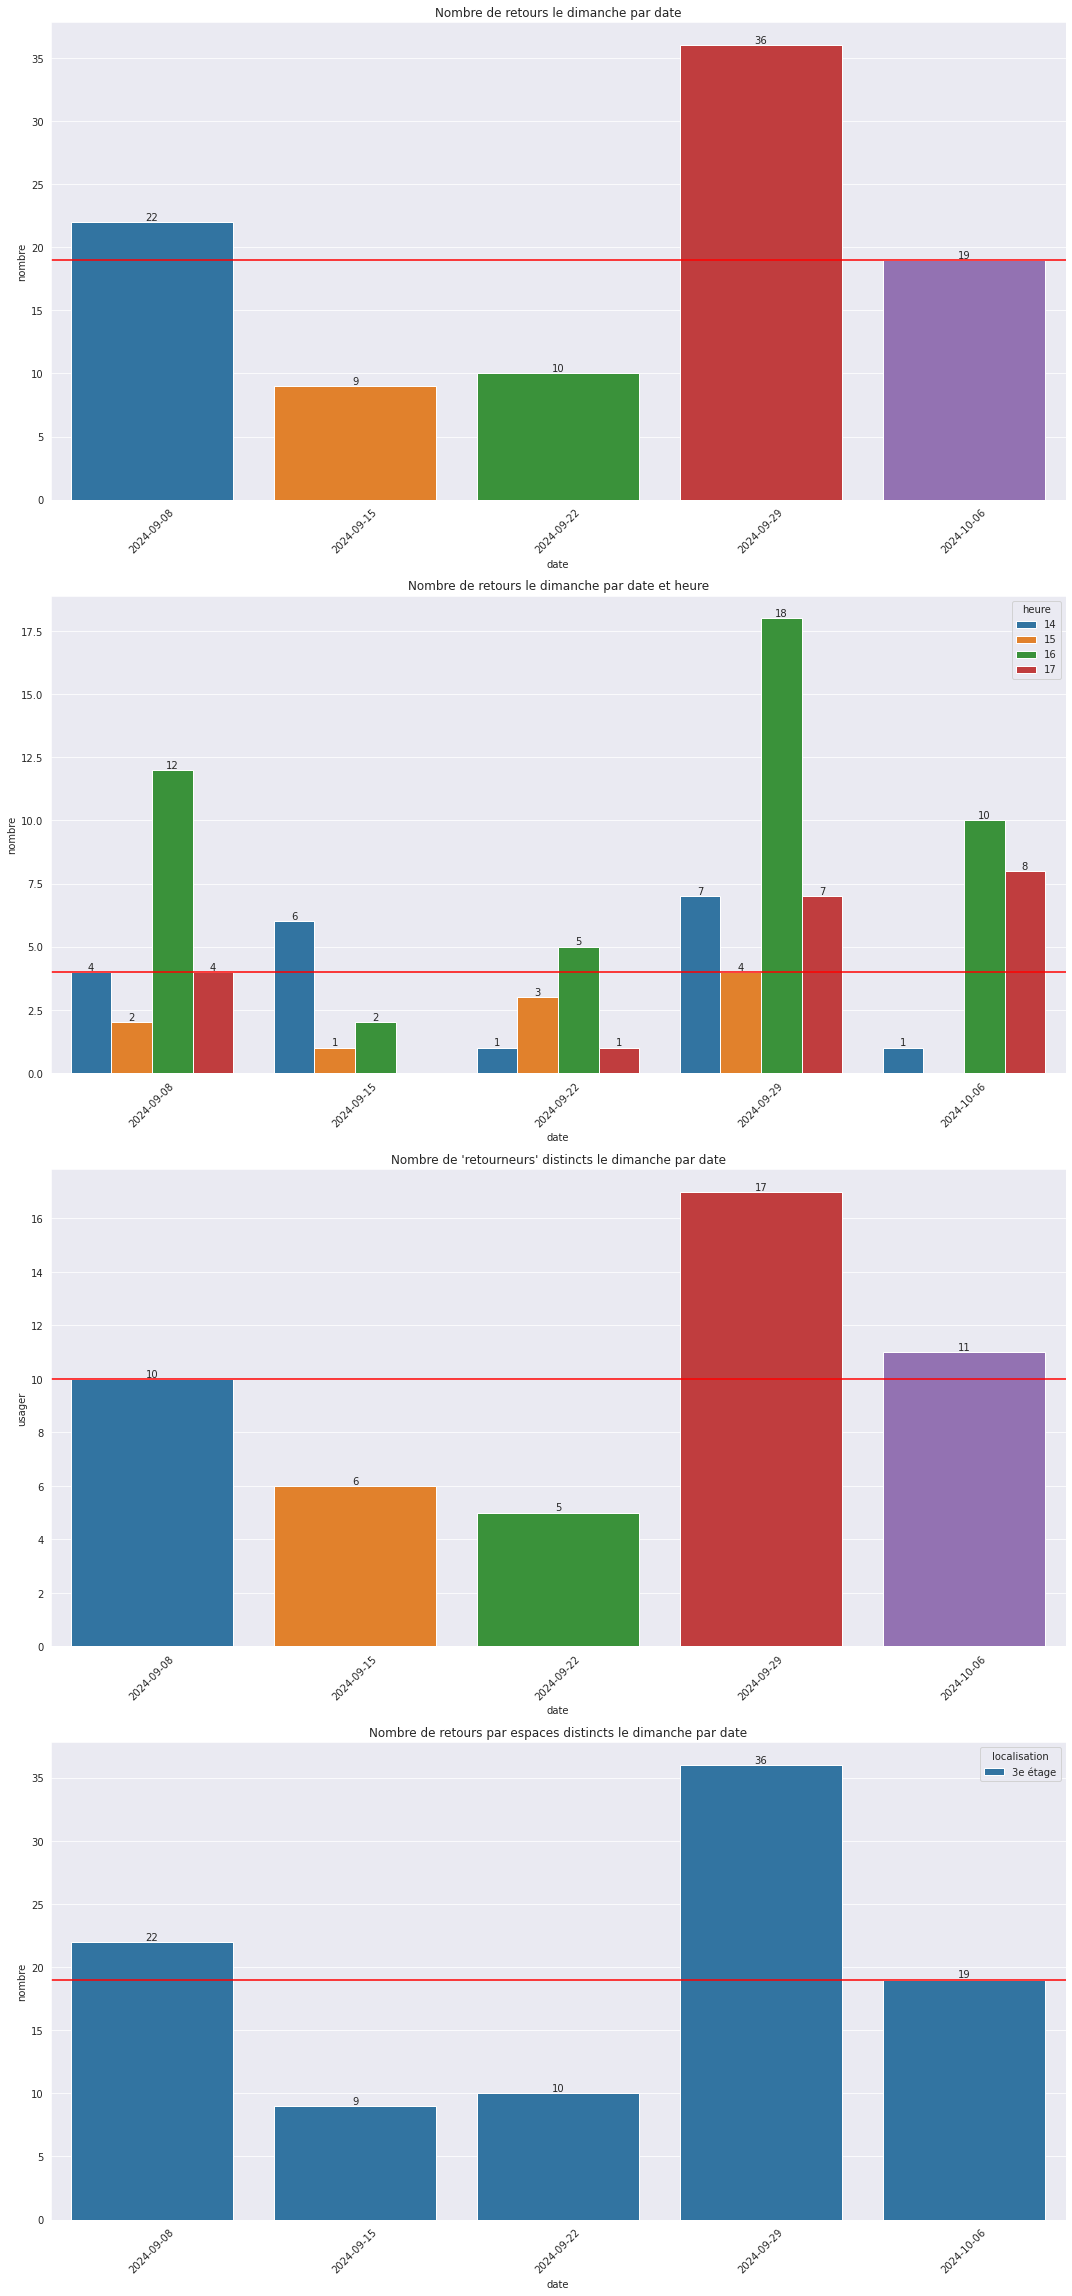

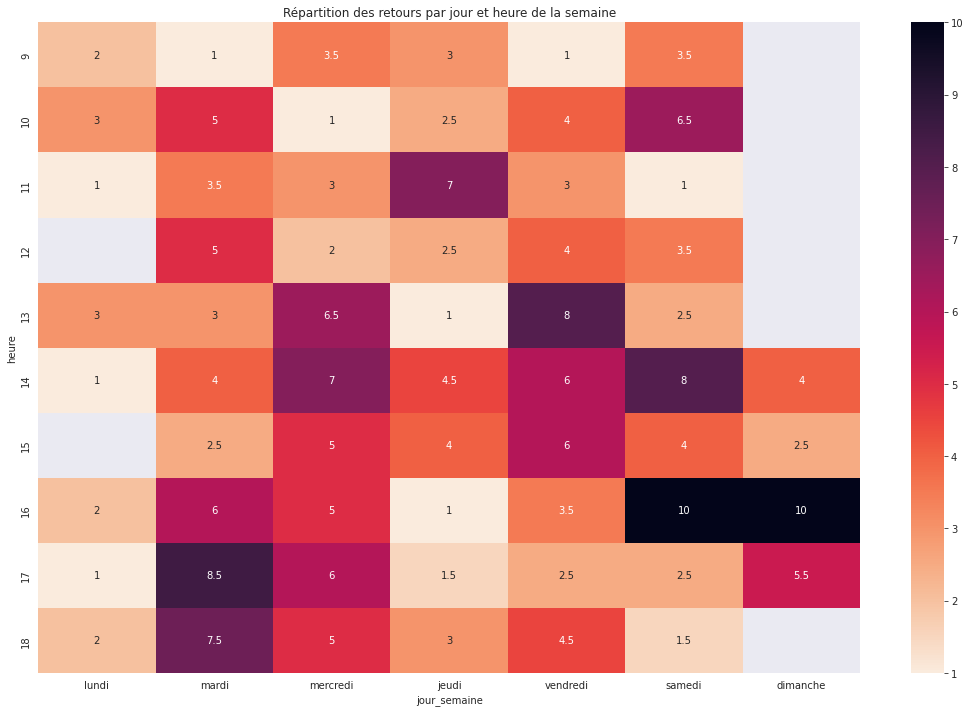

In [18]:
query = f"""SELECT returndate as date_heure, borrowernumber as usager, location
FROM stat_issues
WHERE DATE(returndate) BETWEEN '{date_debut}' AND '{date_fin}'
AND location = 'MED3A'
"""

retours = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
retours.get_df_activite(jourSemaine=6)


n = 4
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=retours.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = retours.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de retours le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=retours.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = retours.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de retours le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=retours.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = retours.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre de 'retourneurs' distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)
    
sns.barplot(data=retours.df_activiteHebdomadaire_parJourLocalisation, x= 'date', y='nombre', hue='localisation', ax=ax[3])
ax[3].axhline(y = retours.df_activiteHebdomadaire_parJourLocalisation['nombre'].median(), color = 'r')    
ax[3].tick_params(axis='x', labelrotation = 45)
ax[3].set_title("Nombre de retours par espaces distincts le dimanche par date")
for i in ax[3].containers:
    ax[3].bar_label(i,)
f.tight_layout()


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(retours.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des retours par jour et heure de la semaine")
f.tight_layout()

## Connexions aux ordinateurs

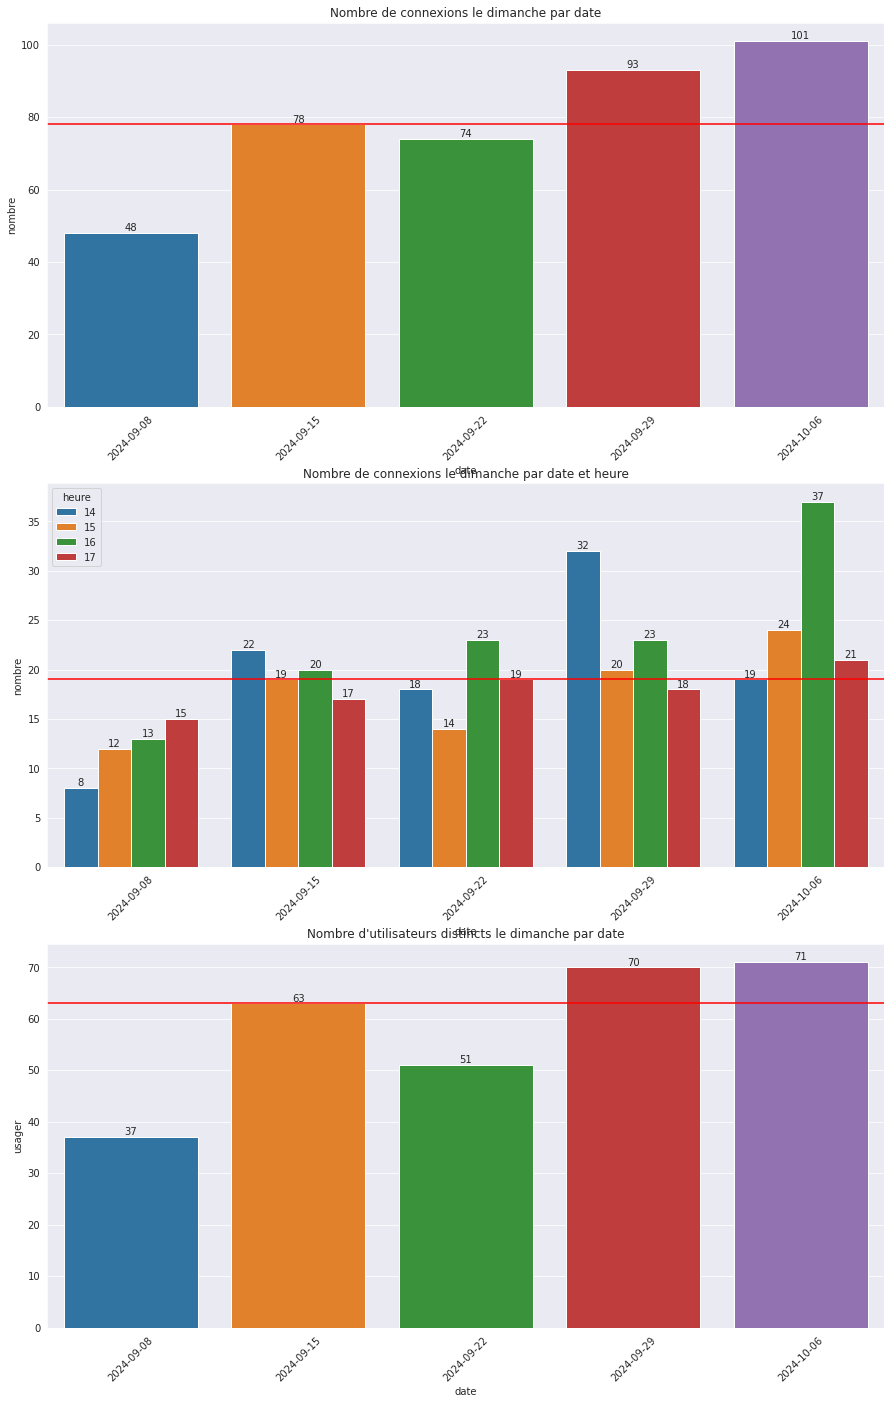

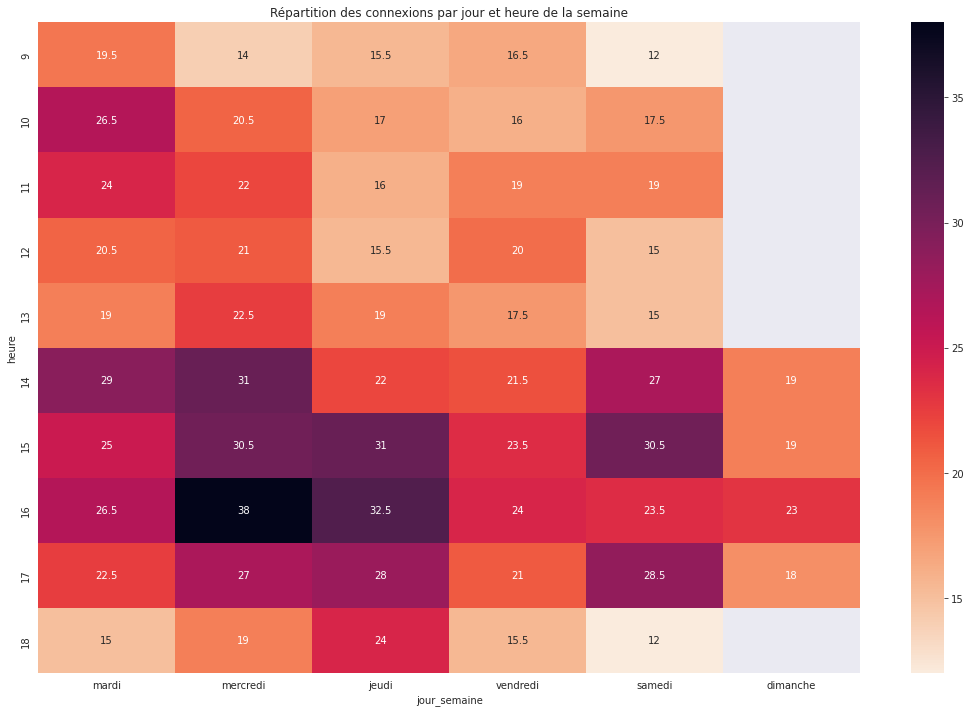

In [19]:
query = f"""SELECT heure_deb as date_heure, borrowernumber as usager
FROM stat_webkiosk
WHERE DATE(heure_deb) BETWEEN '{date_debut}' AND '{date_fin}'
"""
wk = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
wk.get_df_activite(jourSemaine=6)


n = 3
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=wk.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = wk.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de connexions le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=wk.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = wk.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de connexions le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=wk.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = wk.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre d'utilisateurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(wk.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des connexions par jour et heure de la semaine")
f.tight_layout()

## Connexions wifi

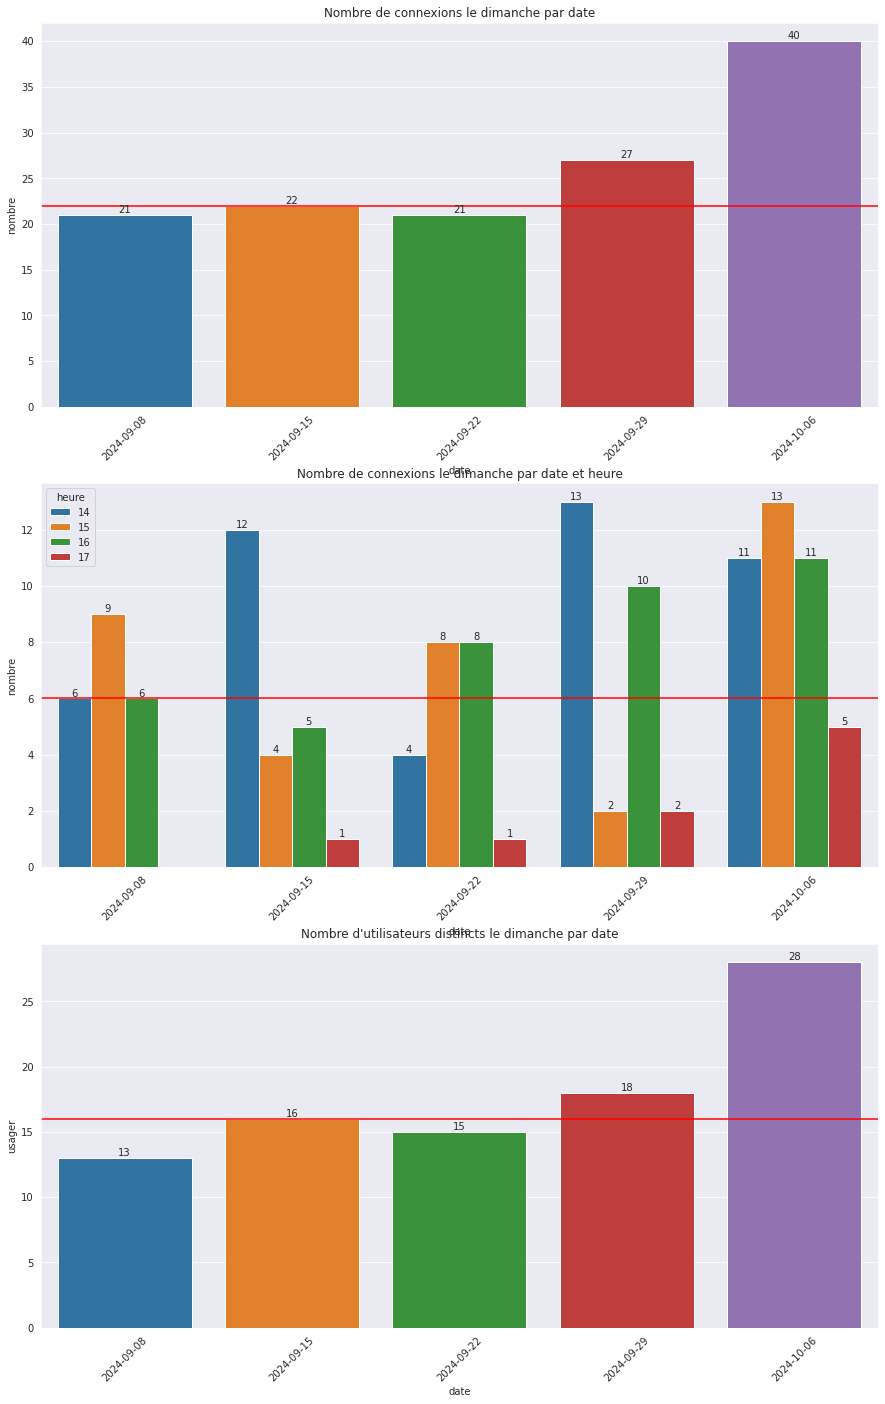

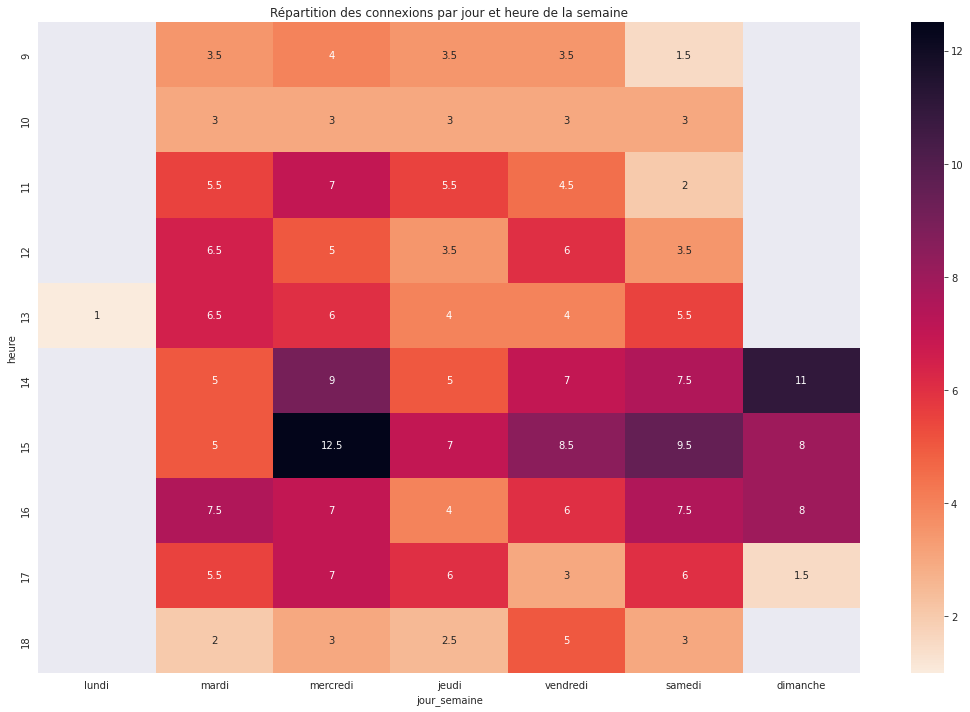

In [20]:
query = f"""SELECT start_wifi as date_heure, borrowernumber as usager
FROM stat_wifi
WHERE DATE(start_wifi) BETWEEN '{date_debut}' AND '{date_fin}'
"""
wifi = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
wifi.get_df_activite(jourSemaine=6)


n = 3
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=wifi.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = wifi.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title('Nombre de connexions le dimanche par date')
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=wifi.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = wifi.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title('Nombre de connexions le dimanche par date et heure')
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=wifi.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = wifi.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre d'utilisateurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(wifi.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des connexions par jour et heure de la semaine")
f.tight_layout()

## Salle d'étude

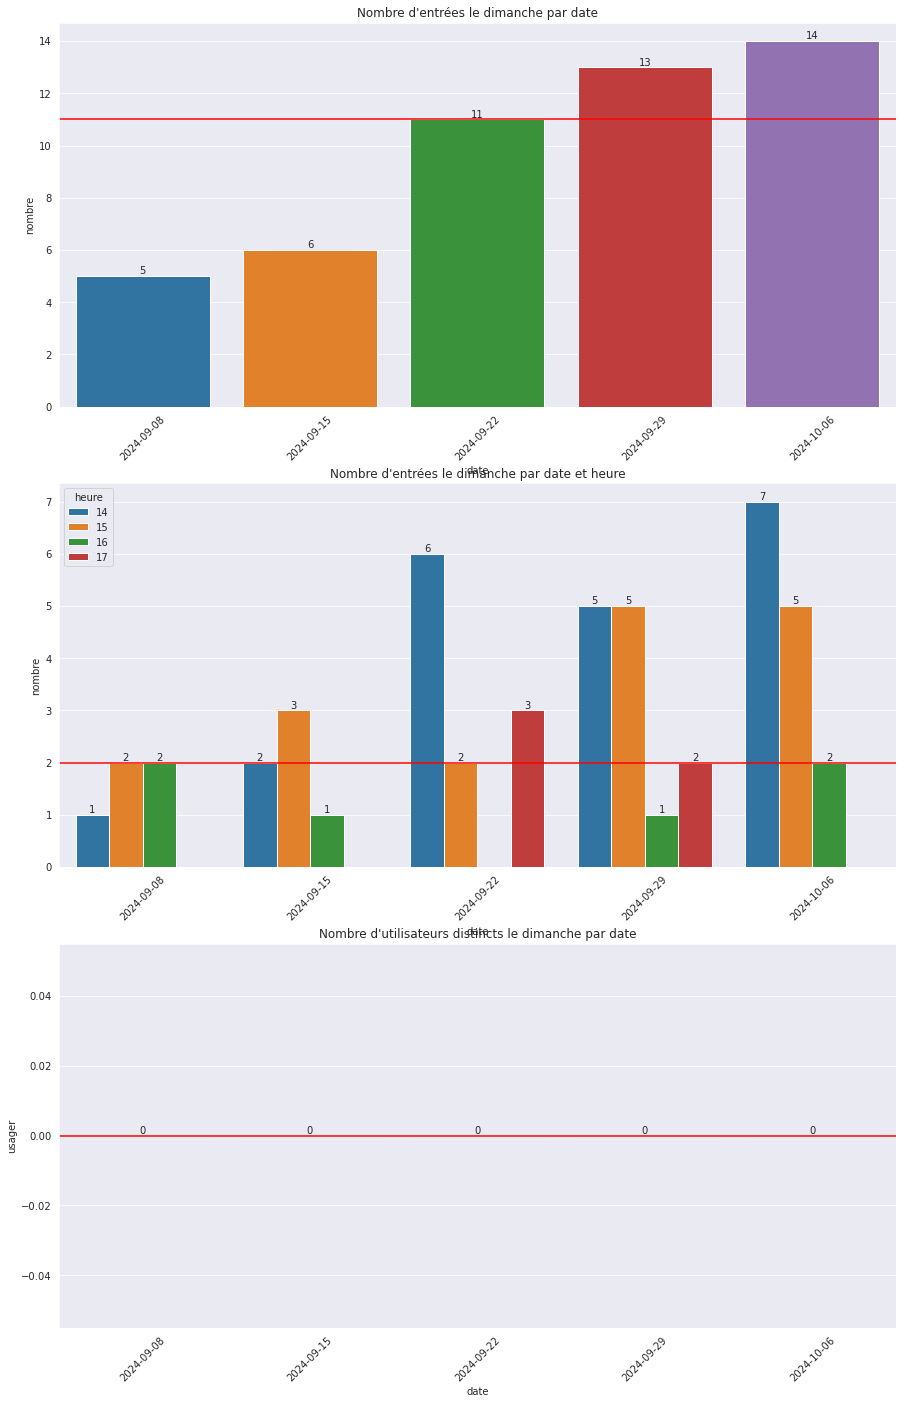

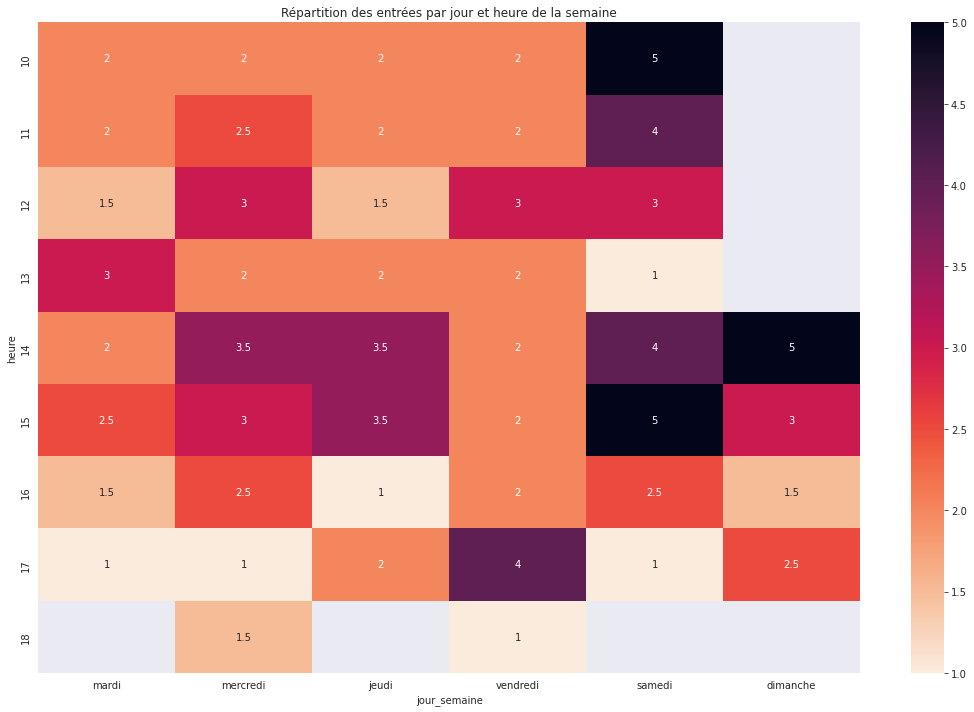

In [21]:
query = f"""SELECT datetime_entree as date_heure, borrowernumber as usager
FROM stat_freq_etude
WHERE DATE(datetime_entree) BETWEEN '{date_debut}' AND '{date_fin}'
"""
etude = StatActivite(db_conn=db_conn, query=query, c2l=c2l)
etude.get_df_activite(jourSemaine=6)


n = 3
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))

sns.barplot(data=etude.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax[0])
ax[0].axhline(y = etude.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_title("Nombre d'entrées le dimanche par date")
for i in ax[0].containers:
    ax[0].bar_label(i,)
    
sns.barplot(data=etude.df_activiteJourSemaineHeure_parPeriode, x= 'date', y='nombre', hue='heure', ax=ax[1])
ax[1].axhline(y = etude.df_activiteJourSemaineHeure_parPeriode['nombre'].median(), color = 'r')    
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].set_title("Nombre d'entrées le dimanche par date et heure")
for i in ax[1].containers:
    ax[1].bar_label(i,)
    
sns.barplot(data=etude.df_activiteJourSemaineUsagers_parPeriode, x= 'date', y='usager', ax=ax[2])
ax[2].axhline(y = etude.df_activiteJourSemaineUsagers_parPeriode['usager'].median(), color = 'r')    
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Nombre d'utilisateurs distincts le dimanche par date")
for i in ax[2].containers:
    ax[2].bar_label(i,)


f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(etude.df_activiteHebdomadaire_parHeure_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des entrées par jour et heure de la semaine")
f.tight_layout()

## Inscriptions

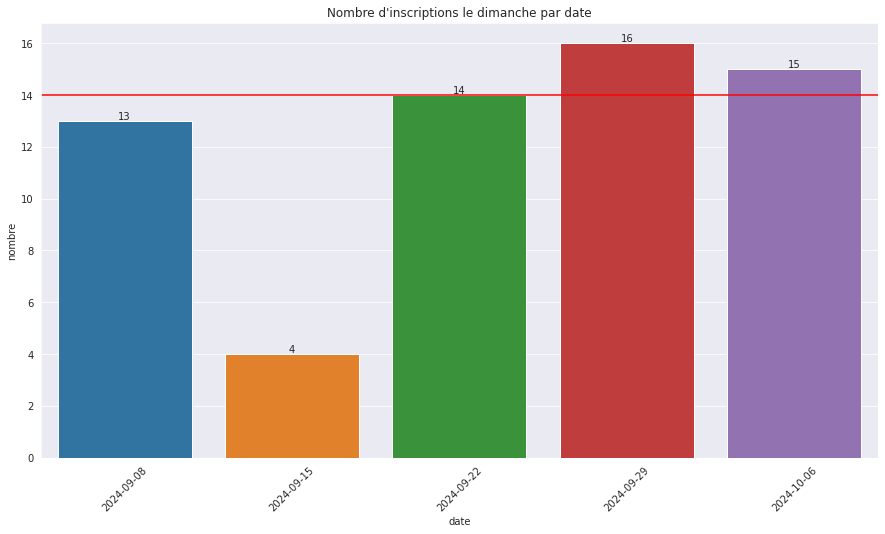

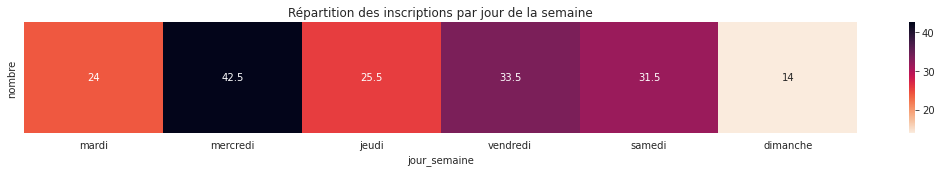

In [22]:
query = f"""SELECT dateenrolled as date_heure, borrowernumber as usager
FROM koha_prod.borrowers
WHERE DATE(dateenrolled) BETWEEN '{date_debut}' AND '{date_fin}'
"""
inscriptions = StatActivite(db_conn=db_conn, query=query, c2l=c2l, is_hour=False)
inscriptions.get_df_activite(jourSemaine=6)


f, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data=inscriptions.df_activiteJourSemaine_parPeriode, x= 'date', y='nombre', ax=ax)
ax.axhline(y = inscriptions.df_activiteJourSemaine_parPeriode['nombre'].median(), color = 'r')    
ax.tick_params(axis='x', labelrotation = 45)
ax.set_title("Nombre d'inscriptions le dimanche par date")
for i in ax.containers:
    ax.bar_label(i,)


f, ax = plt.subplots(figsize=(15, 2.5))
sns.heatmap(inscriptions.df_activiteHebdomadaire_colonneJour, cmap='rocket_r', annot=True, fmt='g', ax=ax)
ax.set_title("Répartition des inscriptions par jour de la semaine")
f.tight_layout()

# Profil des usagers du dimanche

In [23]:
# on prend tous les usagers

query = f"""
                SELECT
                    borrowernumber,
                    cardnumber,
                    title,
                    dateofbirth,
                    city,
                    altcontactcountry,
                    branchcode,
                    categorycode,
                    dateenrolled
                FROM koha_prod.borrowers
                WHERE dateexpiry >= '{date_debut}'
"""
df = pd.read_sql(query, con=db_conn)
adh = Adherent(df=df, db_conn=db_conn, c2l=c2l)
adh.get_adherent_statdb_data()
adh.get_adherent_es_data()

In [24]:
# on récupère pour chaque inscrit le nombre de dimanche venu
prets_s = prets.df[prets.df['jour_semaine'].isin([1, 2, 3, 4, 5])]
retours_s = retours.df[retours.df['jour_semaine'].isin([1, 2, 3, 4, 5])]
wk_s = wk.df[wk.df['jour_semaine'].isin([1, 2, 3, 4, 5])]
wifi_s = wifi.df[wifi.df['jour_semaine'].isin([1, 2, 3, 4, 5])]
etude_s = etude.df[etude.df['jour_semaine'].isin([1, 2, 3, 4, 5])]

prets_s['usager_id'] = 'B' + prets_s['usager'].astype(str)
prets_s['usager_id'] = prets_s['usager_id'].replace('.0$', '', regex=True)
prets_s['date'] = pd.to_datetime(prets_s['date_heure']).dt.strftime('%Y-%m-%d')
nb_venues_prets_s_ = prets_s.groupby(['date', 'usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_prets_s = nb_venues_prets_s_.groupby(['usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_prets_s = nb_venues_prets_s.rename(columns={'nombre':'nb_venues_prets_s'})

retours_s['date'] = pd.to_datetime(retours_s['date_heure']).dt.strftime('%Y-%m-%d')
retours_s['usager_id'] = 'B' + retours_s['usager'].astype(str)
retours_s['usager_id'] = retours_s['usager_id'].replace('.0$', '', regex=True)
nb_venues_retours_s_ = retours_s.groupby(['date', 'usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_retours_s = nb_venues_retours_s_.groupby(['usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_retours_s = nb_venues_retours_s.rename(columns={'nombre':'nb_venues_retours_s'})

wk_s['date'] = pd.to_datetime(wk_s['date_heure']).dt.strftime('%Y-%m-%d')
wk_s['usager_id'] = 'B' + wk_s['usager'].astype(str)
wk_s['usager_id'] = wk_s['usager_id'].replace('.0$', '', regex=True)
nb_venues_wk_s_ = wk_s[~wk_s['usager_id'].isna()].groupby(['date', 'usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_wk_s = nb_venues_wk_s_.groupby(['usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_wk_s = nb_venues_wk_s.rename(columns={'nombre':'nb_venues_wk_s'})

wifi_s['date'] = pd.to_datetime(wifi_s['date_heure']).dt.strftime('%Y-%m-%d')
wifi_s['usager_id'] = 'B' + wifi_s['usager'].astype(str)
wifi_s['usager_id'] = wifi_s['usager_id'].replace('.0$', '', regex=True)
nb_venues_wifi_s_ = wifi_s[~wifi_s['usager_id'].isna()].groupby(['date', 'usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_wifi_s = nb_venues_wifi_s_.groupby(['usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_wifi_s = nb_venues_wifi_s.rename(columns={'nombre':'nb_venues_wifi_s'})

etude_s['date'] = pd.to_datetime(etude_s['date_heure']).dt.strftime('%Y-%m-%d')
etude_s['usager_id'] = 'B' + etude_s['usager'].astype(str)
etude_s['usager_id'] = etude_s['usager_id'].replace('.0$', '', regex=True)
nb_venues_etude_s_ = etude_s[~etude_s['usager_id'].isna()==True].groupby(['date', 'usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_etude_s = nb_venues_etude_s_.groupby(['usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_etude_s = nb_venues_etude_s.rename(columns={'nombre':'nb_venues_etude_s'})

nb_venues_s= nb_venues_prets_s.merge(nb_venues_retours_s, how = 'outer', left_on = 'usager_id', right_on = 'usager_id')
nb_venues_s= nb_venues_s.merge(nb_venues_wk_s, how = 'outer', left_on = 'usager_id', right_on = 'usager_id')
nb_venues_s= nb_venues_s.merge(nb_venues_wifi_s, how = 'outer', left_on = 'usager_id', right_on = 'usager_id')
nb_venues_s= nb_venues_s.merge(nb_venues_etude_s, how = 'outer', left_on = 'usager_id', right_on = 'usager_id')
nb_venues_s= nb_venues_s[nb_venues_s['usager_id'] != 'Bnan']
nb_venues_s= nb_venues_s.fillna(0)
nb_venues_s['nb_venues_s'] = nb_venues_s.sum(axis= 1)
nb_venues_s['venues_s'] = True
nb_venues_s




prets_d = prets.df[prets.df['jour_semaine'].isin([6])]
retours_d = retours.df[retours.df['jour_semaine'].isin([6])]
wk_d = wk.df[wk.df['jour_semaine'].isin([6])]
wifi_d = wifi.df[wifi.df['jour_semaine'].isin([6])]
etude_d = etude.df[etude.df['jour_semaine'].isin([6])]

prets_d['usager_id'] = 'B' + prets_d['usager'].astype(str)
prets_d['usager_id'] = prets_d['usager_id'].replace('.0$', '', regex=True)
prets_d['date'] = pd.to_datetime(prets_d['date_heure']).dt.strftime('%Y-%m-%d')
nb_venues_prets_d_ = prets_d.groupby(['date', 'usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_prets_d = nb_venues_prets_d_.groupby(['usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_prets_d = nb_venues_prets_d.rename(columns={'nombre':'nb_venues_prets_d'})

retours_d['date'] = pd.to_datetime(retours_d['date_heure']).dt.strftime('%Y-%m-%d')
retours_d['usager_id'] = 'B' + retours_d['usager'].astype(str)
retours_d['usager_id'] = retours_d['usager_id'].replace('.0$', '', regex=True)
nb_venues_retours_d_ = retours_d.groupby(['date', 'usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_retours_d = nb_venues_retours_d_.groupby(['usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_retours_d = nb_venues_retours_d.rename(columns={'nombre':'nb_venues_retours_d'})

wk_d['date'] = pd.to_datetime(wk_d['date_heure']).dt.strftime('%Y-%m-%d')
wk_d['usager_id'] = 'B' + wk_d['usager'].astype(str)
wk_d['usager_id'] = wk_d['usager_id'].replace('.0$', '', regex=True)
nb_venues_wk_d_ = wk_d[~wk_d['usager_id'].isna()].groupby(['date', 'usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_wk_d = nb_venues_wk_d_.groupby(['usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_wk_d = nb_venues_wk_d.rename(columns={'nombre':'nb_venues_wk_d'})

wifi_d['date'] = pd.to_datetime(wifi_d['date_heure']).dt.strftime('%Y-%m-%d')
wifi_d['usager_id'] = 'B' + wifi_d['usager'].astype(str)
wifi_d['usager_id'] = wifi_d['usager_id'].replace('.0$', '', regex=True)
nb_venues_wifi_d_ = wifi_d[~wifi_d['usager_id'].isna()].groupby(['date', 'usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_wifi_d = nb_venues_wifi_d_.groupby(['usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_wifi_d = nb_venues_wifi_d.rename(columns={'nombre':'nb_venues_wifi_d'})

etude_d['date'] = pd.to_datetime(etude_d['date_heure']).dt.strftime('%Y-%m-%d')
etude_d['usager_id'] = 'B' + etude_d['usager'].astype(str)
etude_d['usager_id'] = etude_d['usager_id'].replace('.0$', '', regex=True)
nb_venues_etude_d_ = etude_d[~etude_d['usager_id'].isna()==True].groupby(['date', 'usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_etude_d = nb_venues_etude_d_.groupby(['usager_id'])['nombre'].sum().to_frame().reset_index()
nb_venues_etude_d = nb_venues_etude_d.rename(columns={'nombre':'nb_venues_etude_d'})

nb_venues_d = nb_venues_prets_d.merge(nb_venues_retours_d, how = 'outer', left_on = 'usager_id', right_on = 'usager_id')
nb_venues_d = nb_venues_d.merge(nb_venues_wk_d, how = 'outer', left_on = 'usager_id', right_on = 'usager_id')
nb_venues_d = nb_venues_d.merge(nb_venues_wifi_d, how = 'outer', left_on = 'usager_id', right_on = 'usager_id')
nb_venues_d = nb_venues_d.merge(nb_venues_etude_d, how = 'outer', left_on = 'usager_id', right_on = 'usager_id')
nb_venues_d = nb_venues_d[nb_venues_d['usager_id'] != 'Bnan']
nb_venues_d = nb_venues_d.fillna(0)
nb_venues_d['nb_venues_d'] = nb_venues_d.sum(axis= 1)
nb_venues_d['venues_d'] = True

In [25]:
nb_venues = nb_venues_s.merge(nb_venues_d, how='outer', left_on='usager_id', right_on='usager_id')
nb_venues[['venues_s', 'venues_d']] = nb_venues[['venues_s', 'venues_d']].fillna(False)
nb_venues = nb_venues.fillna('0')

adh.df['user_id'] = 'B' + adh.df['borrowernumber'].astype(str)
nb_venues = nb_venues.merge(adh.df, how='left', left_on='usager_id',right_on='user_id')

nb_venues['venues'] = False
nb_venues.loc[nb_venues['venues_s'] == True, 'venues'] = True
nb_venues.loc[nb_venues['venues_d'] == True, 'venues'] = True
nb_venues[['venues_s', 'venues_d', 'venues']]

adh_ = nb_venues[(nb_venues['venues'] == True)]
adh_d = nb_venues[(nb_venues['venues_d'] == True)]


In [26]:
adh_frequentants_dimanche = adh_d[adh_d['venues_d'] == True]
adh_frequentants = adh_[(adh_['venues_s'] == True ) | (adh_['venues_d'] == True)]

In [27]:
part_adh_venus_dimanche = round(len(adh_frequentants_dimanche) / len(adh_frequentants) * 100, 1)
print(f"Parmi les adhérents venus au moins une fois à la Médiathèque depuis septembre 2022, {part_adh_venus_dimanche} % sont venus au moins une fois le dimanche.")

Parmi les adhérents venus au moins une fois à la Médiathèque depuis septembre 2022, 16.8 % sont venus au moins une fois le dimanche.


### Origine géographique

#### Roubaix et autres villes

In [28]:
adh_frequentants_ville = adh_frequentants.groupby(['adh_geo_ville'])['usager_id'].count().reset_index()
adh_frequentants_ville['part'] = round((adh_frequentants_ville['usager_id'] / adh_frequentants_ville['usager_id'].sum()) * 100, 0)
adh_frequentants_ville = adh_frequentants_ville.rename(columns={'adh_geo_ville': 'ville', 'usager_id': 'fréquentants'})

adh_frequentants_dimanche_ville = adh_frequentants_dimanche.groupby(['adh_geo_ville'])['usager_id'].count().reset_index()
adh_frequentants_dimanche_ville['part_dimanche'] = round((adh_frequentants_dimanche_ville['usager_id'] / adh_frequentants_dimanche_ville['usager_id'].sum()) * 100, 0)
adh_frequentants_dimanche_ville = adh_frequentants_dimanche_ville.rename(columns={'adh_geo_ville': 'ville', 'usager_id': 'fréquentants_dimanche'})

adh_frequentants_ville = adh_frequentants_ville.merge(adh_frequentants_dimanche_ville, how='left', on='ville')
adh_frequentants_ville = adh_frequentants_ville.fillna('0')
for c in ['fréquentants', 'part', 'fréquentants_dimanche', 'part_dimanche']:
    adh_frequentants_ville[c] = adh_frequentants_ville[c].astype(int)
adh_frequentants_ville

,ville,fréquentants,part,fréquentants_dimanche,part_dimanche
0,AUTRE,87,4,12,4
1,CROIX,120,6,22,6
2,HEM,58,3,16,5
3,LEERS,16,1,1,0
4,LILLE,30,1,3,1
5,LYS-LEZ-LANNOY,22,1,2,1
6,MARCQ-EN-BAROEUL,13,1,0,0
7,MONS-EN-BAROEUL,13,1,1,0
8,MOUVAUX,11,1,2,1
9,ROUBAIX,1471,72,249,73


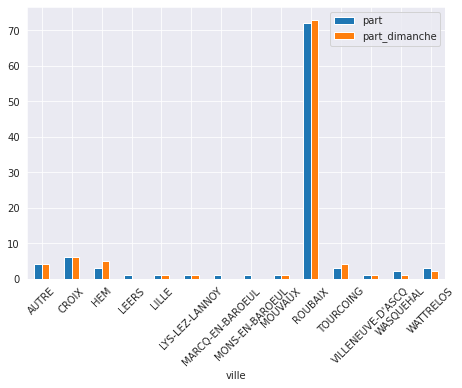

In [29]:
adh_frequentants_ville_plot = adh_frequentants_ville[['ville', 'part', 'part_dimanche']]
adh_frequentants_ville_plot = adh_frequentants_ville_plot.set_index('ville')
ax = adh_frequentants_ville_plot.plot.bar(rot=0, figsize=(7.5, 5))
ax.tick_params(axis='x', labelrotation = 45)

#### Par quartiers de Roubaix

In [30]:
adh_roubaisiens_frequentants = adh_frequentants[adh_frequentants['adh_geo_gentilite'] == 'Roubaisien']
adh_roubaisiens_frequentants = adh_roubaisiens_frequentants[~adh_roubaisiens_frequentants['geo_rbx_secteur'].isna()]

adh_roubaisiens_frequentants_dimanche = adh_frequentants_dimanche[adh_frequentants_dimanche['adh_geo_gentilite'] == 'Roubaisien']
adh_roubaisiens_frequentants_dimanche = adh_roubaisiens_frequentants_dimanche[~adh_roubaisiens_frequentants_dimanche['geo_rbx_secteur'].isna()]

In [31]:
adh_roubaisiens_frequentants_iris = adh_roubaisiens_frequentants.groupby(['geo_rbx_secteur'])['usager_id'].count().reset_index()
adh_roubaisiens_frequentants_iris['part'] = round((adh_roubaisiens_frequentants_iris['usager_id'] / adh_roubaisiens_frequentants_iris['usager_id'].sum()) * 100, 0)
adh_roubaisiens_frequentants_iris = adh_roubaisiens_frequentants_iris.rename(columns={'geo_rbx_secteur': 'quartier', 'usager_id': 'fréquentants'})

adh_roubaisiens_frequentants_dimanche_iris = adh_roubaisiens_frequentants_dimanche.groupby(['geo_rbx_secteur'])['usager_id'].count().reset_index()
adh_roubaisiens_frequentants_dimanche_iris['part_dimanche'] = round((adh_roubaisiens_frequentants_dimanche_iris['usager_id'] / adh_roubaisiens_frequentants_dimanche_iris['usager_id'].sum()) * 100, 0)
adh_roubaisiens_frequentants_dimanche_iris = adh_roubaisiens_frequentants_dimanche_iris.rename(columns={'geo_rbx_secteur': 'quartier', 'usager_id': 'fréquentants_dimanche'})

adh_roubaisiens_frequentants_iris = adh_roubaisiens_frequentants_iris.merge(adh_roubaisiens_frequentants_dimanche_iris, how='left', on='quartier')
adh_roubaisiens_frequentants_iris = adh_roubaisiens_frequentants_iris.fillna('0')
for c in ['fréquentants', 'part', 'fréquentants_dimanche', 'part_dimanche']:
    adh_roubaisiens_frequentants_iris[c] = adh_roubaisiens_frequentants_iris[c].astype(int)
adh_roubaisiens_frequentants_iris

,quartier,fréquentants,part,fréquentants_dimanche,part_dimanche
0,QUARTIERS CENTRE,238,24,41,23
1,QUARTIERS EST,190,19,39,22
2,QUARTIERS NORD,212,21,27,15
3,QUARTIERS OUEST,170,17,29,16
4,QUARTIERS SUD,199,20,40,23


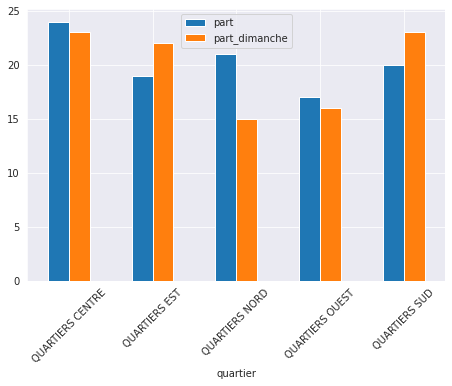

In [32]:
adh_roubaisiens_frequentants_iris_plot = adh_roubaisiens_frequentants_iris[['quartier', 'part', 'part_dimanche']]
adh_roubaisiens_frequentants_iris_plot = adh_roubaisiens_frequentants_iris_plot.set_index('quartier')
ax = adh_roubaisiens_frequentants_iris_plot.plot.bar(rot=0, figsize=(7.5, 5))
ax.tick_params(axis='x', labelrotation = 45)

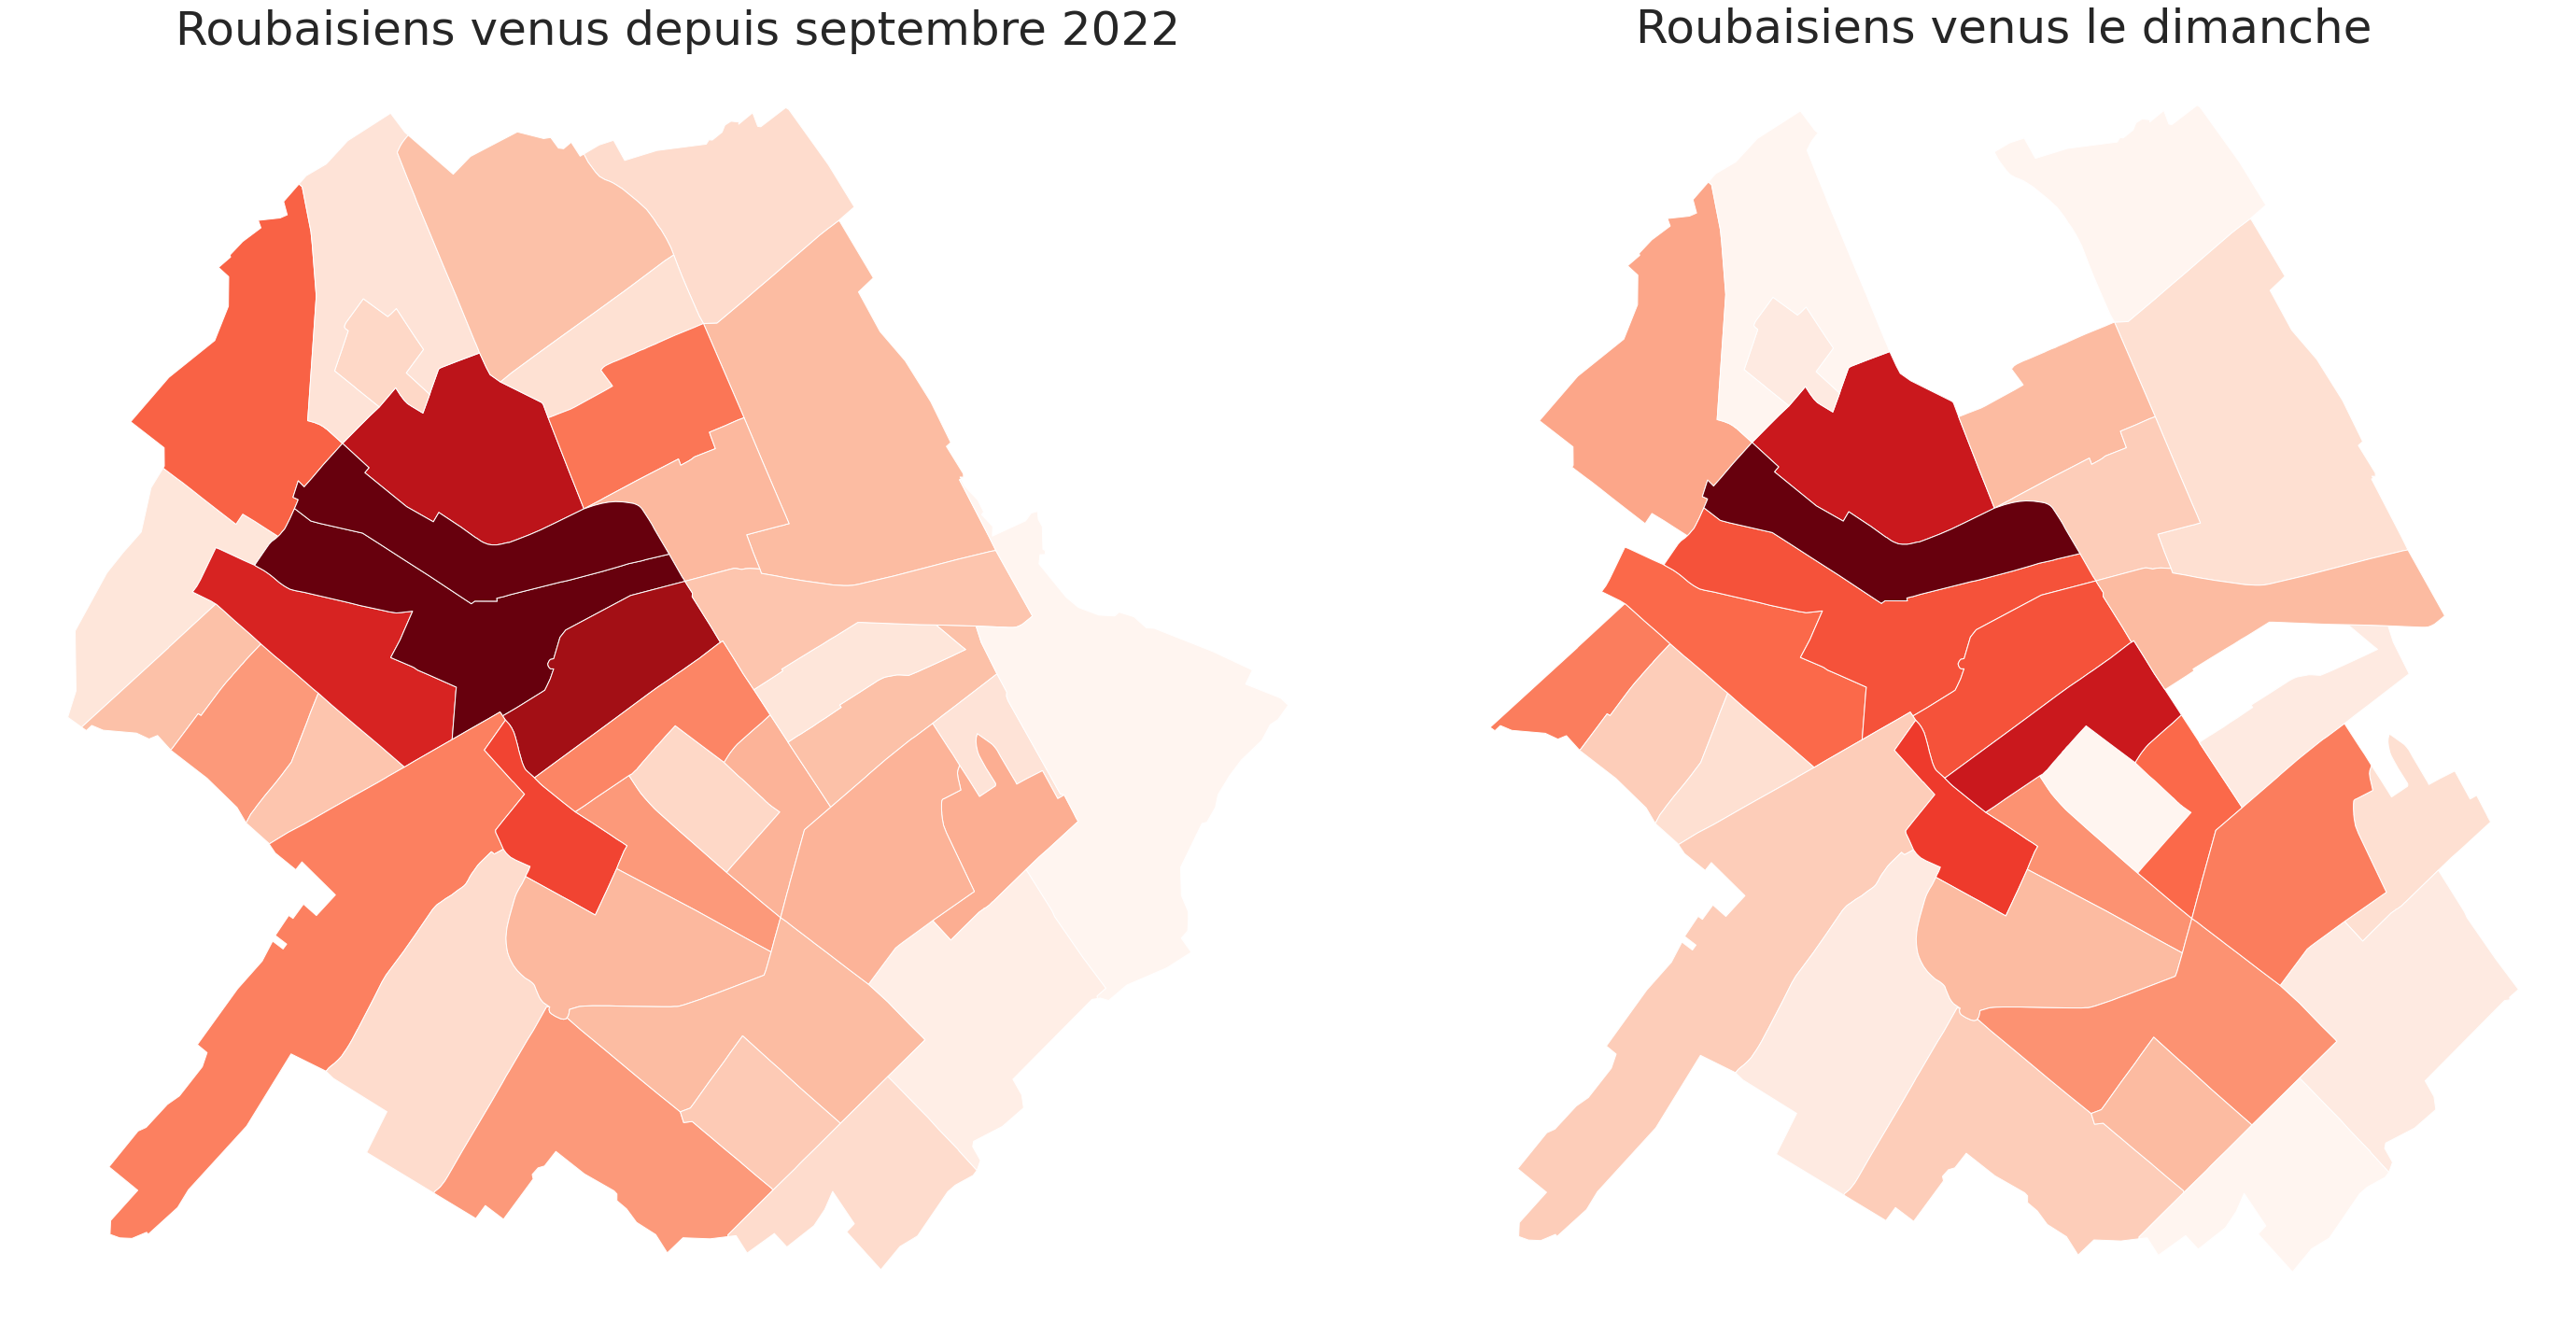

In [33]:
file = '/home/kibini/kibini_prod/public/data/rbx.geojson'
rbx_map = gpd.read_file(file)
rbx_map = rbx_map[['dcomiris', 'geometry']]

adh_['nb'] = 1
adh__gr = adh_[~adh_['adh_geo_rbx_iris_code'].isna()].groupby(['adh_geo_rbx_iris_code'])['nb'].sum().to_frame().reset_index()
adh__map = adh__gr.merge(rbx_map, how='left', left_on = 'adh_geo_rbx_iris_code', right_on = 'dcomiris')
adh__map = adh__map[~adh__map['dcomiris'].isna()]
adh__map = gpd.GeoDataFrame(adh__map, geometry='geometry')

adh_d['nb'] = 1
adh_d_gr = adh_d[~adh_d['adh_geo_rbx_iris_code'].isna()].groupby(['adh_geo_rbx_iris_code'])['nb'].sum().to_frame().reset_index()
adh_d_map = adh_d_gr.merge(rbx_map, how='left', left_on = 'adh_geo_rbx_iris_code', right_on = 'dcomiris')
adh_d_map = adh_d_map[~adh_d_map['dcomiris'].isna()]
adh_d_map = gpd.GeoDataFrame(adh_d_map, geometry='geometry')

f, ax = plt.subplots(1, 2, figsize=(40,20))
ax[0].axis('off')
ax[0].set_title('Roubaisiens venus depuis septembre 2022', fontsize=50)
adh__map.plot(column='nb', cmap='Reds', ax=ax[0])
ax[1].axis('off')
adh_d_map.plot(column='nb', cmap='Reds', ax=ax[1])
ax[1].set_title('Roubaisiens venus le dimanche', fontsize=50)
f.tight_layout()

### Fréquentants par âge

In [34]:
adh_frequentants_age = adh_frequentants.groupby(['adh_age_lib3'])['usager_id'].count().reset_index()
adh_frequentants_age['part'] = round((adh_frequentants_age['usager_id'] / adh_frequentants_age['usager_id'].sum()) * 100, 0)
adh_frequentants_age = adh_frequentants_age.rename(columns={'adh_age_lib3': 'âge', 'usager_id': 'fréquentants'})

adh_frequentants_dimanche_age = adh_frequentants_dimanche.groupby(['adh_age_lib3'])['usager_id'].count().reset_index()
adh_frequentants_dimanche_age['part_dimanche'] = round((adh_frequentants_dimanche_age['usager_id'] / adh_frequentants_dimanche_age['usager_id'].sum()) * 100, 0)
adh_frequentants_dimanche_age = adh_frequentants_dimanche_age.rename(columns={'adh_age_lib3': 'âge', 'usager_id': 'fréquentants_dimanche'})

adh_frequentants_age = adh_frequentants_age.merge(adh_frequentants_dimanche_age, how='left', on='âge')
adh_frequentants_age = adh_frequentants_age.fillna('0')
for c in ['fréquentants', 'part', 'fréquentants_dimanche', 'part_dimanche']:
    adh_frequentants_age[c] = adh_frequentants_age[c].astype(int)
adh_frequentants_age

,âge,fréquentants,part,fréquentants_dimanche,part_dimanche
0,0 - 14 ans,359,18,97,29
1,15 - 24 ans,490,24,93,27
2,25 - 64 ans,1019,50,128,38
3,65 ans et plus,163,8,22,6
4,Non pertinent,4,0,0,0


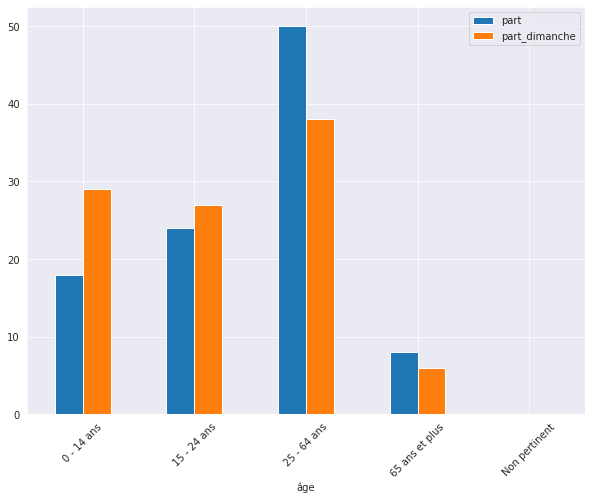

In [35]:
adh_frequentants_age_plot = adh_frequentants_age[['âge', 'part', 'part_dimanche']]
adh_frequentants_age_plot = adh_frequentants_age_plot.set_index('âge')
ax = adh_frequentants_age_plot.plot.bar(rot=0, figsize=(10, 7.5))
ax.tick_params(axis='x', labelrotation = 45)

In [36]:
adh_frequentants_age = adh_frequentants.groupby(['adh_age_lib1'])['usager_id'].count().reset_index()
adh_frequentants_age['part'] = round((adh_frequentants_age['usager_id'] / adh_frequentants_age['usager_id'].sum()) * 100, 0)
adh_frequentants_age = adh_frequentants_age.rename(columns={'adh_age_lib1': 'âge', 'usager_id': 'fréquentants'})

adh_frequentants_dimanche_age = adh_frequentants_dimanche.groupby(['adh_age_lib1'])['usager_id'].count().reset_index()
adh_frequentants_dimanche_age['part_dimanche'] = round((adh_frequentants_dimanche_age['usager_id'] / adh_frequentants_dimanche_age['usager_id'].sum()) * 100, 0)
adh_frequentants_dimanche_age = adh_frequentants_dimanche_age.rename(columns={'adh_age_lib1': 'âge', 'usager_id': 'fréquentants_dimanche'})

adh_frequentants_age = adh_frequentants_age.merge(adh_frequentants_dimanche_age, how='left', on='âge')
adh_frequentants_age = adh_frequentants_age.fillna('0')
for c in ['fréquentants', 'part', 'fréquentants_dimanche', 'part_dimanche']:
    adh_frequentants_age[c] = adh_frequentants_age[c].astype(int)
adh_frequentants_age

,âge,fréquentants,part,fréquentants_dimanche,part_dimanche
0,0 - 2 ans,2,0,1,0
1,03 - 5 ans,12,1,1,0
2,06 - 10 ans,138,7,31,9
3,11 - 14 ans,207,10,64,19
4,15 - 17 ans,147,7,37,11
5,18 - 19 ans,114,6,21,6
6,20 - 24 ans,229,11,35,10
7,25 - 29 ans,170,8,12,4
8,30 - 39 ans,227,11,25,7
9,40 - 54 ans,422,21,66,19


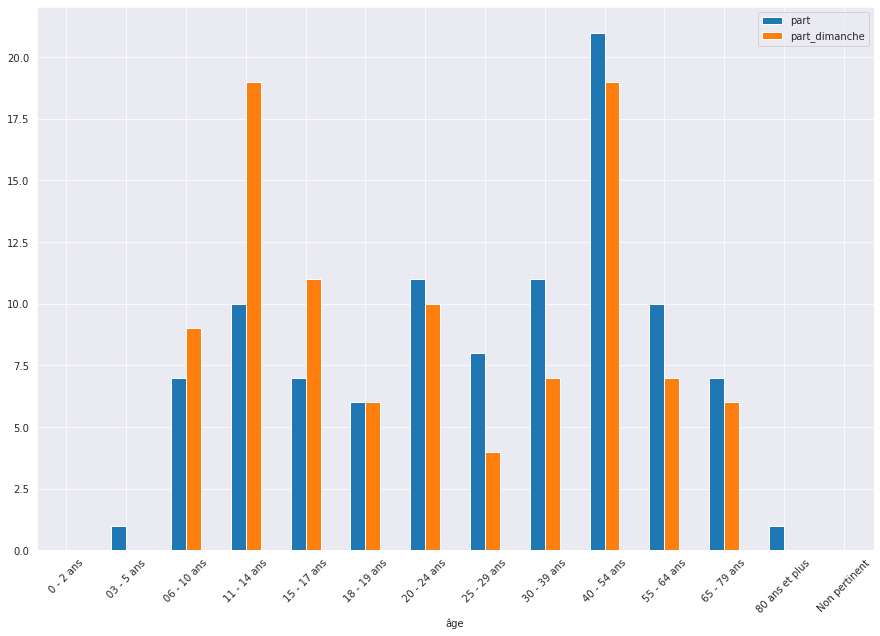

In [37]:
adh_frequentants_age_plot = adh_frequentants_age[['âge', 'part', 'part_dimanche']]
adh_frequentants_age_plot = adh_frequentants_age_plot.set_index('âge')
ax = adh_frequentants_age_plot.plot.bar(rot=0, figsize=(15, 10))
ax.tick_params(axis='x', labelrotation = 45)

### Par sexe

In [38]:
adh_frequentants_sexe = adh_frequentants.groupby(['adh_sexe'])['usager_id'].count().reset_index()
adh_frequentants_sexe['part'] = round((adh_frequentants_sexe['usager_id'] / adh_frequentants_sexe['usager_id'].sum()) * 100, 0)
adh_frequentants_sexe = adh_frequentants_sexe.rename(columns={'adh_sexe': 'sexe', 'usager_id': 'fréquentants'})

adh_frequentants_dimanche_sexe = adh_frequentants_dimanche.groupby(['adh_sexe'])['usager_id'].count().reset_index()
adh_frequentants_dimanche_sexe['part_dimanche'] = round((adh_frequentants_dimanche_sexe['usager_id'] / adh_frequentants_dimanche_sexe['usager_id'].sum()) * 100, 0)
adh_frequentants_dimanche_sexe = adh_frequentants_dimanche_sexe.rename(columns={'adh_sexe': 'sexe', 'usager_id': 'fréquentants_dimanche'})

adh_frequentants_sexe = adh_frequentants_sexe[adh_frequentants_sexe['sexe'] != 'Non pertinent']
adh_frequentants_sexe = adh_frequentants_sexe.merge(adh_frequentants_dimanche_sexe, how='left', on='sexe')
adh_frequentants_sexe = adh_frequentants_sexe.fillna('0')
for c in ['fréquentants', 'part', 'fréquentants_dimanche', 'part_dimanche']:
    adh_frequentants_sexe[c] = adh_frequentants_sexe[c].astype(int)
adh_frequentants_sexe

,sexe,fréquentants,part,fréquentants_dimanche,part_dimanche
0,Inconnu,2031,100,340,100


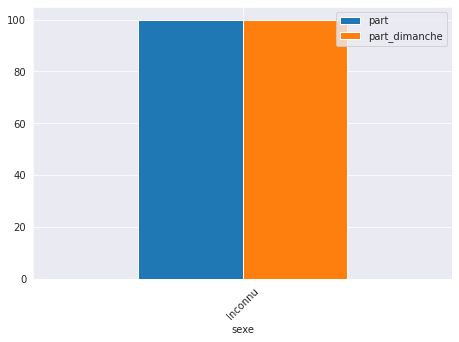

In [39]:
adh_frequentants_sexe_plot = adh_frequentants_sexe[['sexe', 'part', 'part_dimanche']]
adh_frequentants_sexe_plot = adh_frequentants_sexe_plot.set_index('sexe')
ax = adh_frequentants_sexe_plot.plot.bar(rot=0, figsize=(7.5, 5))
ax.tick_params(axis='x', labelrotation = 45)

# Action culturelle

In [40]:
file2023 = '/bdc_roubaix/partage_media/Action culturelle/2023/1er semestre/Documents de travail/FréquentationAC_2023_semestre1.xlsx'
stats_ac2023 = pd.read_excel(file2023, sheet_name=1)
stats_ac2023['Date'] = pd.to_datetime(stats_ac2023['Date'])

In [41]:
stats_ac2023_dimanche = stats_ac2023[stats_ac2023['Date'].dt.dayofweek == 6]
stats_ac2023_dimanche = stats_ac2023_dimanche[['Date', 'Nombre de personnes venues']]
stats_ac2023_dimanche.columns= ['date', 'participants']

In [42]:
stats_ac2023_dimanche

,date,participants
0,2023-01-08,25.0
1,2023-01-08,45.0
4,2023-01-15,80.0
9,2023-01-22,70.0
14,2023-01-29,36.0
21,2023-02-05,52.0
22,2023-02-05,34.0
41,2023-03-05,36.0
47,2023-03-12,13.0
48,2023-03-12,6.0


In [43]:
query = f"""SELECT *
FROM stat_action_culturelle
WHERE date BETWEEN '2022-09-05' AND '2022-12-31' AND DAYOFWEEK(date) = 1
"""
stats_ac2022_dimanche = pd.read_sql(query, con=db_conn)
stats_ac2022_dimanche = stats_ac2022_dimanche[['date', 'participants']]

In [44]:
stats_ac_dimanche = pd.concat([stats_ac2022_dimanche, stats_ac2023_dimanche])
stats_ac_dimanche = stats_ac_dimanche[~stats_ac_dimanche['participants'].isna()]
stats_ac_dimanche['participants'] = stats_ac_dimanche['participants'].astype(int)
stats_ac_dimanche_date = stats_ac_dimanche.groupby('date')['participants'].sum().reset_index()
stats_ac_dimanche_date['date'] = stats_ac_dimanche_date['date'].dt.strftime('%Y-%m-%d')

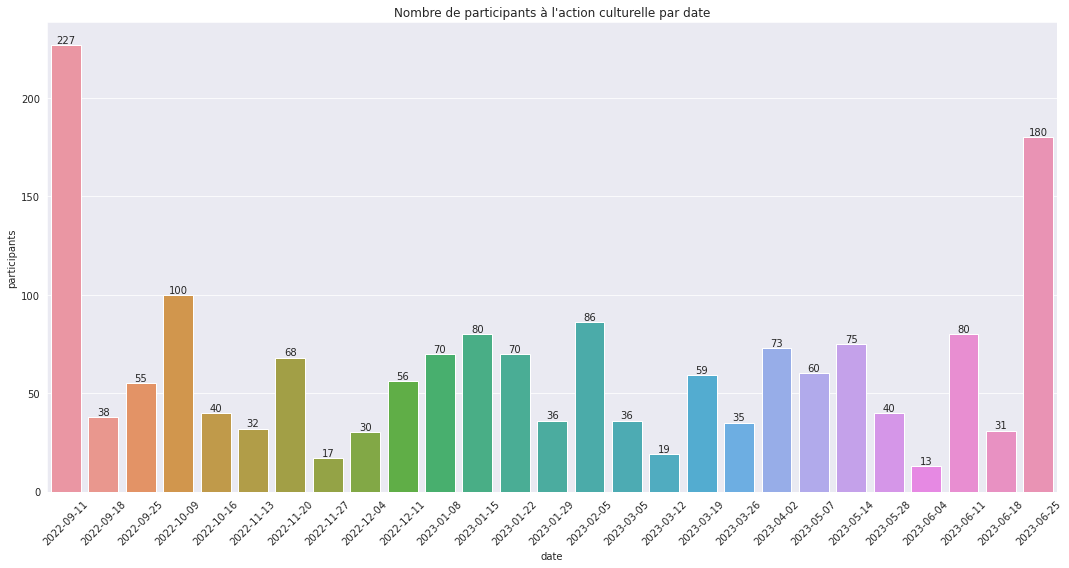

In [45]:
n = 1
h = n * 8
l = 15
f, ax = plt.subplots(n, figsize=(l, h))


sns.barplot(data=stats_ac_dimanche_date, x= 'date', y='participants', ax=ax)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_title("Nombre de participants à l'action culturelle par date")
for i in ax.containers:
    ax.bar_label(i,)
f.tight_layout()